# Edinburgh Modellig

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.font_manager as fm
import xgboost as xgb
import shap
from scipy.spatial import cKDTree

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

# Load modelling functions
import sys
sys.path.append('../../scripts')  # go up one folder, into scripts/

from modelling import (
    prepare_data,
    run_modelling_pipeline,
    map_gwr_coefficients,
    calculate_t_values,
    categorise_significance,
    plot_significance,
    geographically_weighted_rf
)

## 1. Import Data

In [3]:
# Import data
edinburgh_airbnb = gpd.read_file('../../data/edinburgh/airbnb_per_edinburgh_glx.gpkg')
edinburgh_tourism_fs = gpd.read_file('../../data/edinburgh/edinburgh_glx_tourism_pois.gpkg')

In [4]:
# Merge the two datasets on glx_id keeping only one geometry column
edinburgh_airbnb_tourism_fs = edinburgh_tourism_fs.merge(edinburgh_airbnb, on='glx_id', how='left')

# Drop geometry_x and rename geometry_y to geometry
edinburgh_airbnb_tourism_fs.drop(columns=['geometry_x'], inplace=True)
edinburgh_airbnb_tourism_fs.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [5]:
# Create total_pois_log column
edinburgh_airbnb_tourism_fs['total_pois_log'] = np.log1p(edinburgh_airbnb_tourism_fs['total_pois'])

## 2. Data Exploration

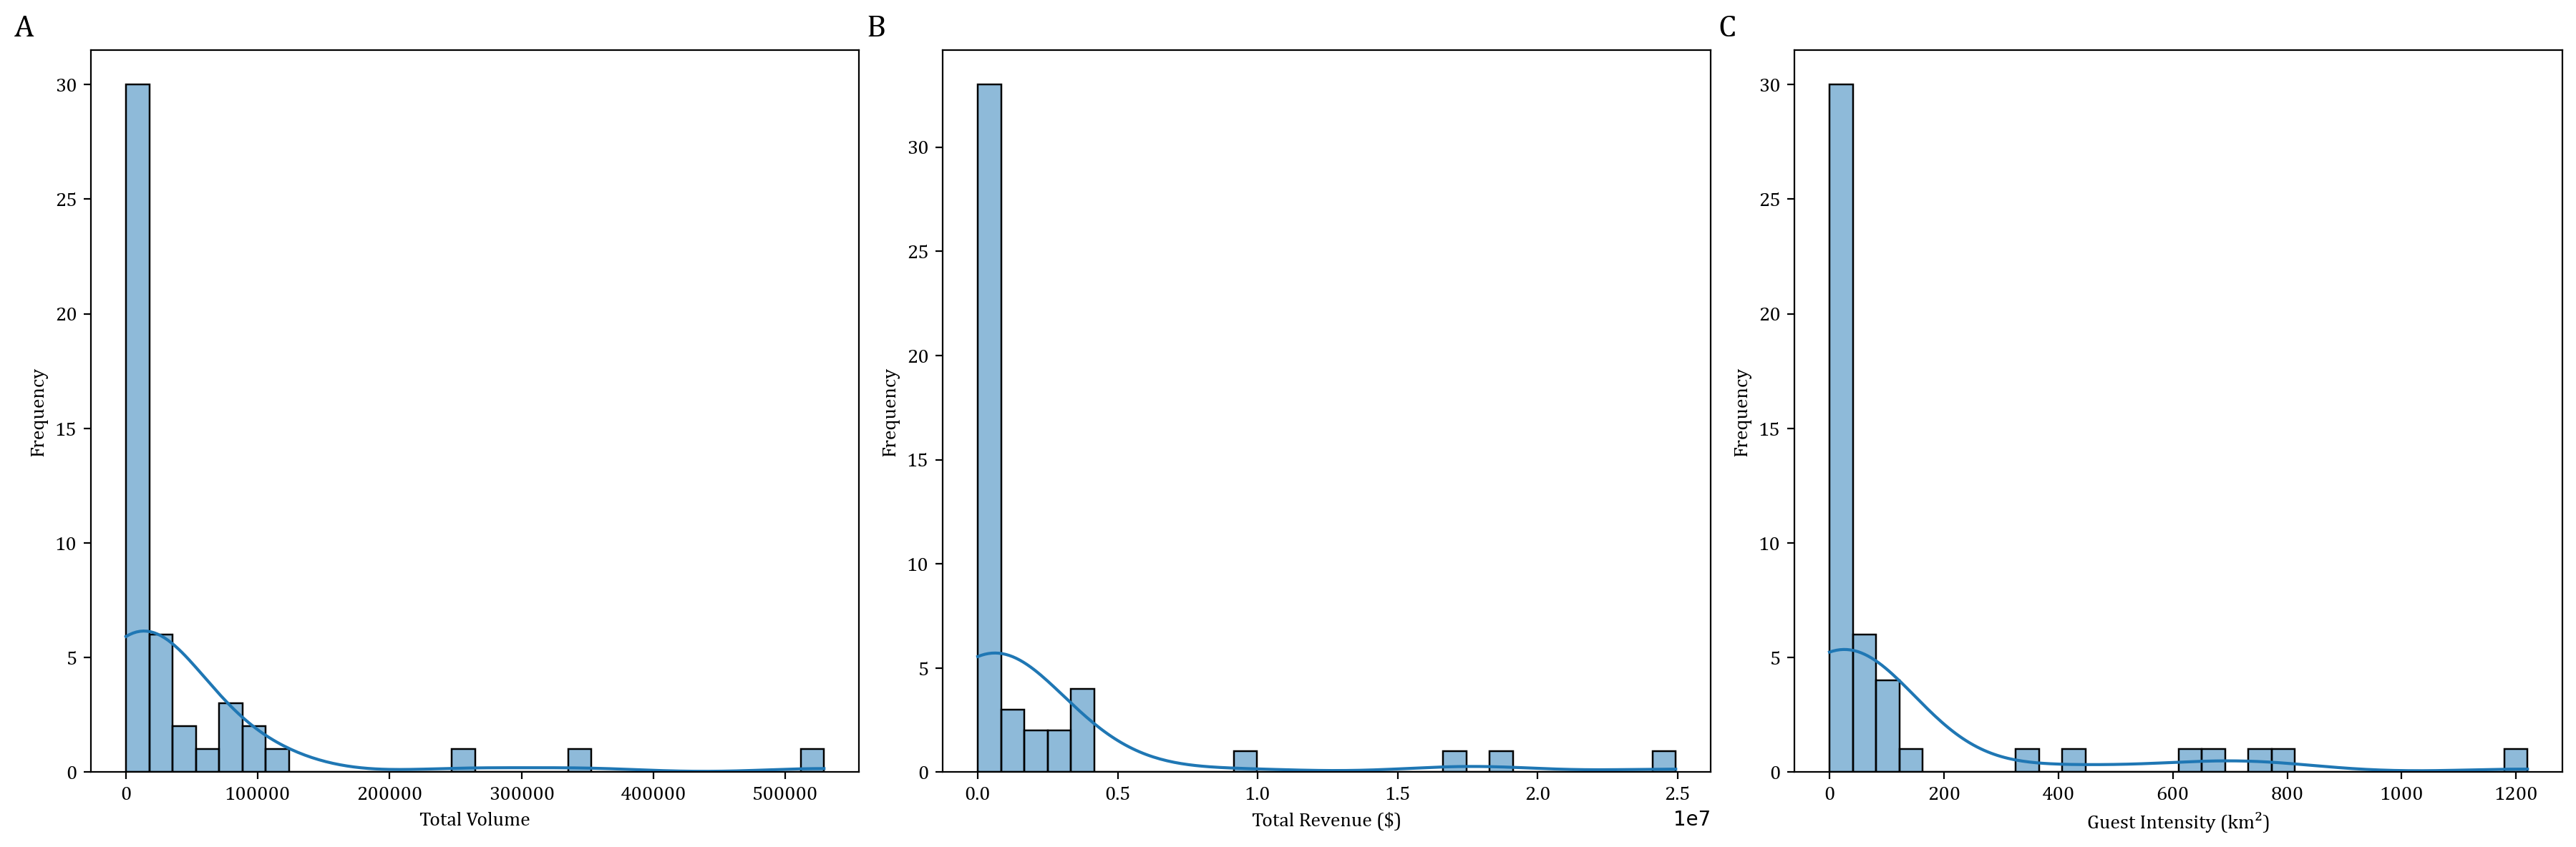

In [6]:
# Create plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Total Volume
sns.histplot(edinburgh_airbnb_tourism_fs['total_volume'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Total Volume', fontproperties=cambria_prop)
axes[0].set_ylabel('Frequency', fontproperties=cambria_prop)

# Plot 2: Total Revenue
sns.histplot(edinburgh_airbnb_tourism_fs['total_revenue'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel('Total Revenue ($)', fontproperties=cambria_prop)
axes[1].set_ylabel('Frequency', fontproperties=cambria_prop)

# Plot 3: Tourism Intensity
sns.histplot(edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'], bins=30, kde=True, ax=axes[2])
axes[2].set_xlabel('Guest Intensity (km²)', fontproperties=cambria_prop)
axes[2].set_ylabel('Frequency', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()

In [10]:
edinburgh_airbnb_tourism_fs.columns.tolist()

['glx_id',
 'air_travel',
 'arts_other',
 'bars_nightlife',
 'cafes_bakeries',
 'cultural_institution',
 'dining_other',
 'entertainment_nightlife',
 'event_space',
 'fast_food',
 'food_drink_production',
 'full_service_restaurant',
 'high_end',
 'historic_landmark',
 'leisure_activity_center',
 'local_public_transit',
 'lodging',
 'major_attraction',
 'major_transit_hub',
 'mobility_services',
 'nature_trail',
 'outdoors_other',
 'park_garden',
 'public_art',
 'public_plaza_square',
 'retail_books_hobbies',
 'retail_fashion_apparel',
 'retail_food_beverage',
 'retail_gifts_misc',
 'retail_health_beauty',
 'retail_home_electronics',
 'retail_luxury',
 'retail_markets_plazas',
 'retail_other',
 'rural_agricultural',
 'tourism_services',
 'transport_infrastructure',
 'travel_other',
 'waterfront_river',
 'total_pois',
 'comb_name',
 'area_km2',
 'air_travel_density',
 'arts_other_density',
 'bars_nightlife_density',
 'cafes_bakeries_density',
 'cultural_institution_density',
 'dining_oth

In [11]:
# Define the non-logged features
features = [
    'air_travel_density',
    'arts_other_density',
    'bars_nightlife_density',
    'cafes_bakeries_density',
    'cultural_institution_density',
    'dining_other_density',
    'entertainment_nightlife_density',
    'event_space_density',
    'fast_food_density',
    'food_drink_production_density',
    'full_service_restaurant_density',
    'high_end_density',
    'historic_landmark_density',
    'leisure_activity_center_density',
    'local_public_transit_density',
    'lodging_density',
    'major_attraction_density',
    'major_transit_hub_density',
    'mobility_services_density',
    'nature_trail_density',
    'outdoors_other_density',
    'park_garden_density',
    'public_art_density',
    'public_plaza_square_density',
    'retail_books_hobbies_density',
    'retail_fashion_apparel_density',
    'retail_food_beverage_density',
    'retail_gifts_misc_density',
    'retail_health_beauty_density',
    'retail_home_electronics_density',
    'retail_luxury_density',
    'retail_markets_plazas_density',
    'retail_other_density',
    'rural_agricultural_density',
    'tourism_services_density',
    'transport_infrastructure_density',
    'travel_other_density',
    'waterfront_river_density'
    ]

# Define the logged features
features_logged = [
    'air_travel_density_log',
    'arts_other_density_log',
    'bars_nightlife_density_log',
    'cafes_bakeries_density_log',
    'cultural_institution_density_log',
    'dining_other_density_log',
    'entertainment_nightlife_density_log',
    'event_space_density_log',
    'fast_food_density_log',
    'food_drink_production_density_log',
    'full_service_restaurant_density_log',
    'high_end_density_log',
    'historic_landmark_density_log',
    'leisure_activity_center_density_log',
    'local_public_transit_density_log',
    'lodging_density_log',
    'major_attraction_density_log',
    'major_transit_hub_density_log',
    'mobility_services_density_log',
    'nature_trail_density_log',
    'outdoors_other_density_log',
    'park_garden_density_log',
    'public_art_density_log',
    'public_plaza_square_density_log',
    'retail_books_hobbies_density_log',
    'retail_fashion_apparel_density_log',
    'retail_food_beverage_density_log',
    'retail_gifts_misc_density_log',
    'retail_health_beauty_density_log',
    'retail_home_electronics_density_log',
    'retail_luxury_density_log',
    'retail_markets_plazas_density_log',
    'retail_other_density_log',
    'rural_agricultural_density_log',
    'tourism_services_density_log',
    'transport_infrastructure_density_log',
    'travel_other_density_log',
    'waterfront_river_density_log'
]

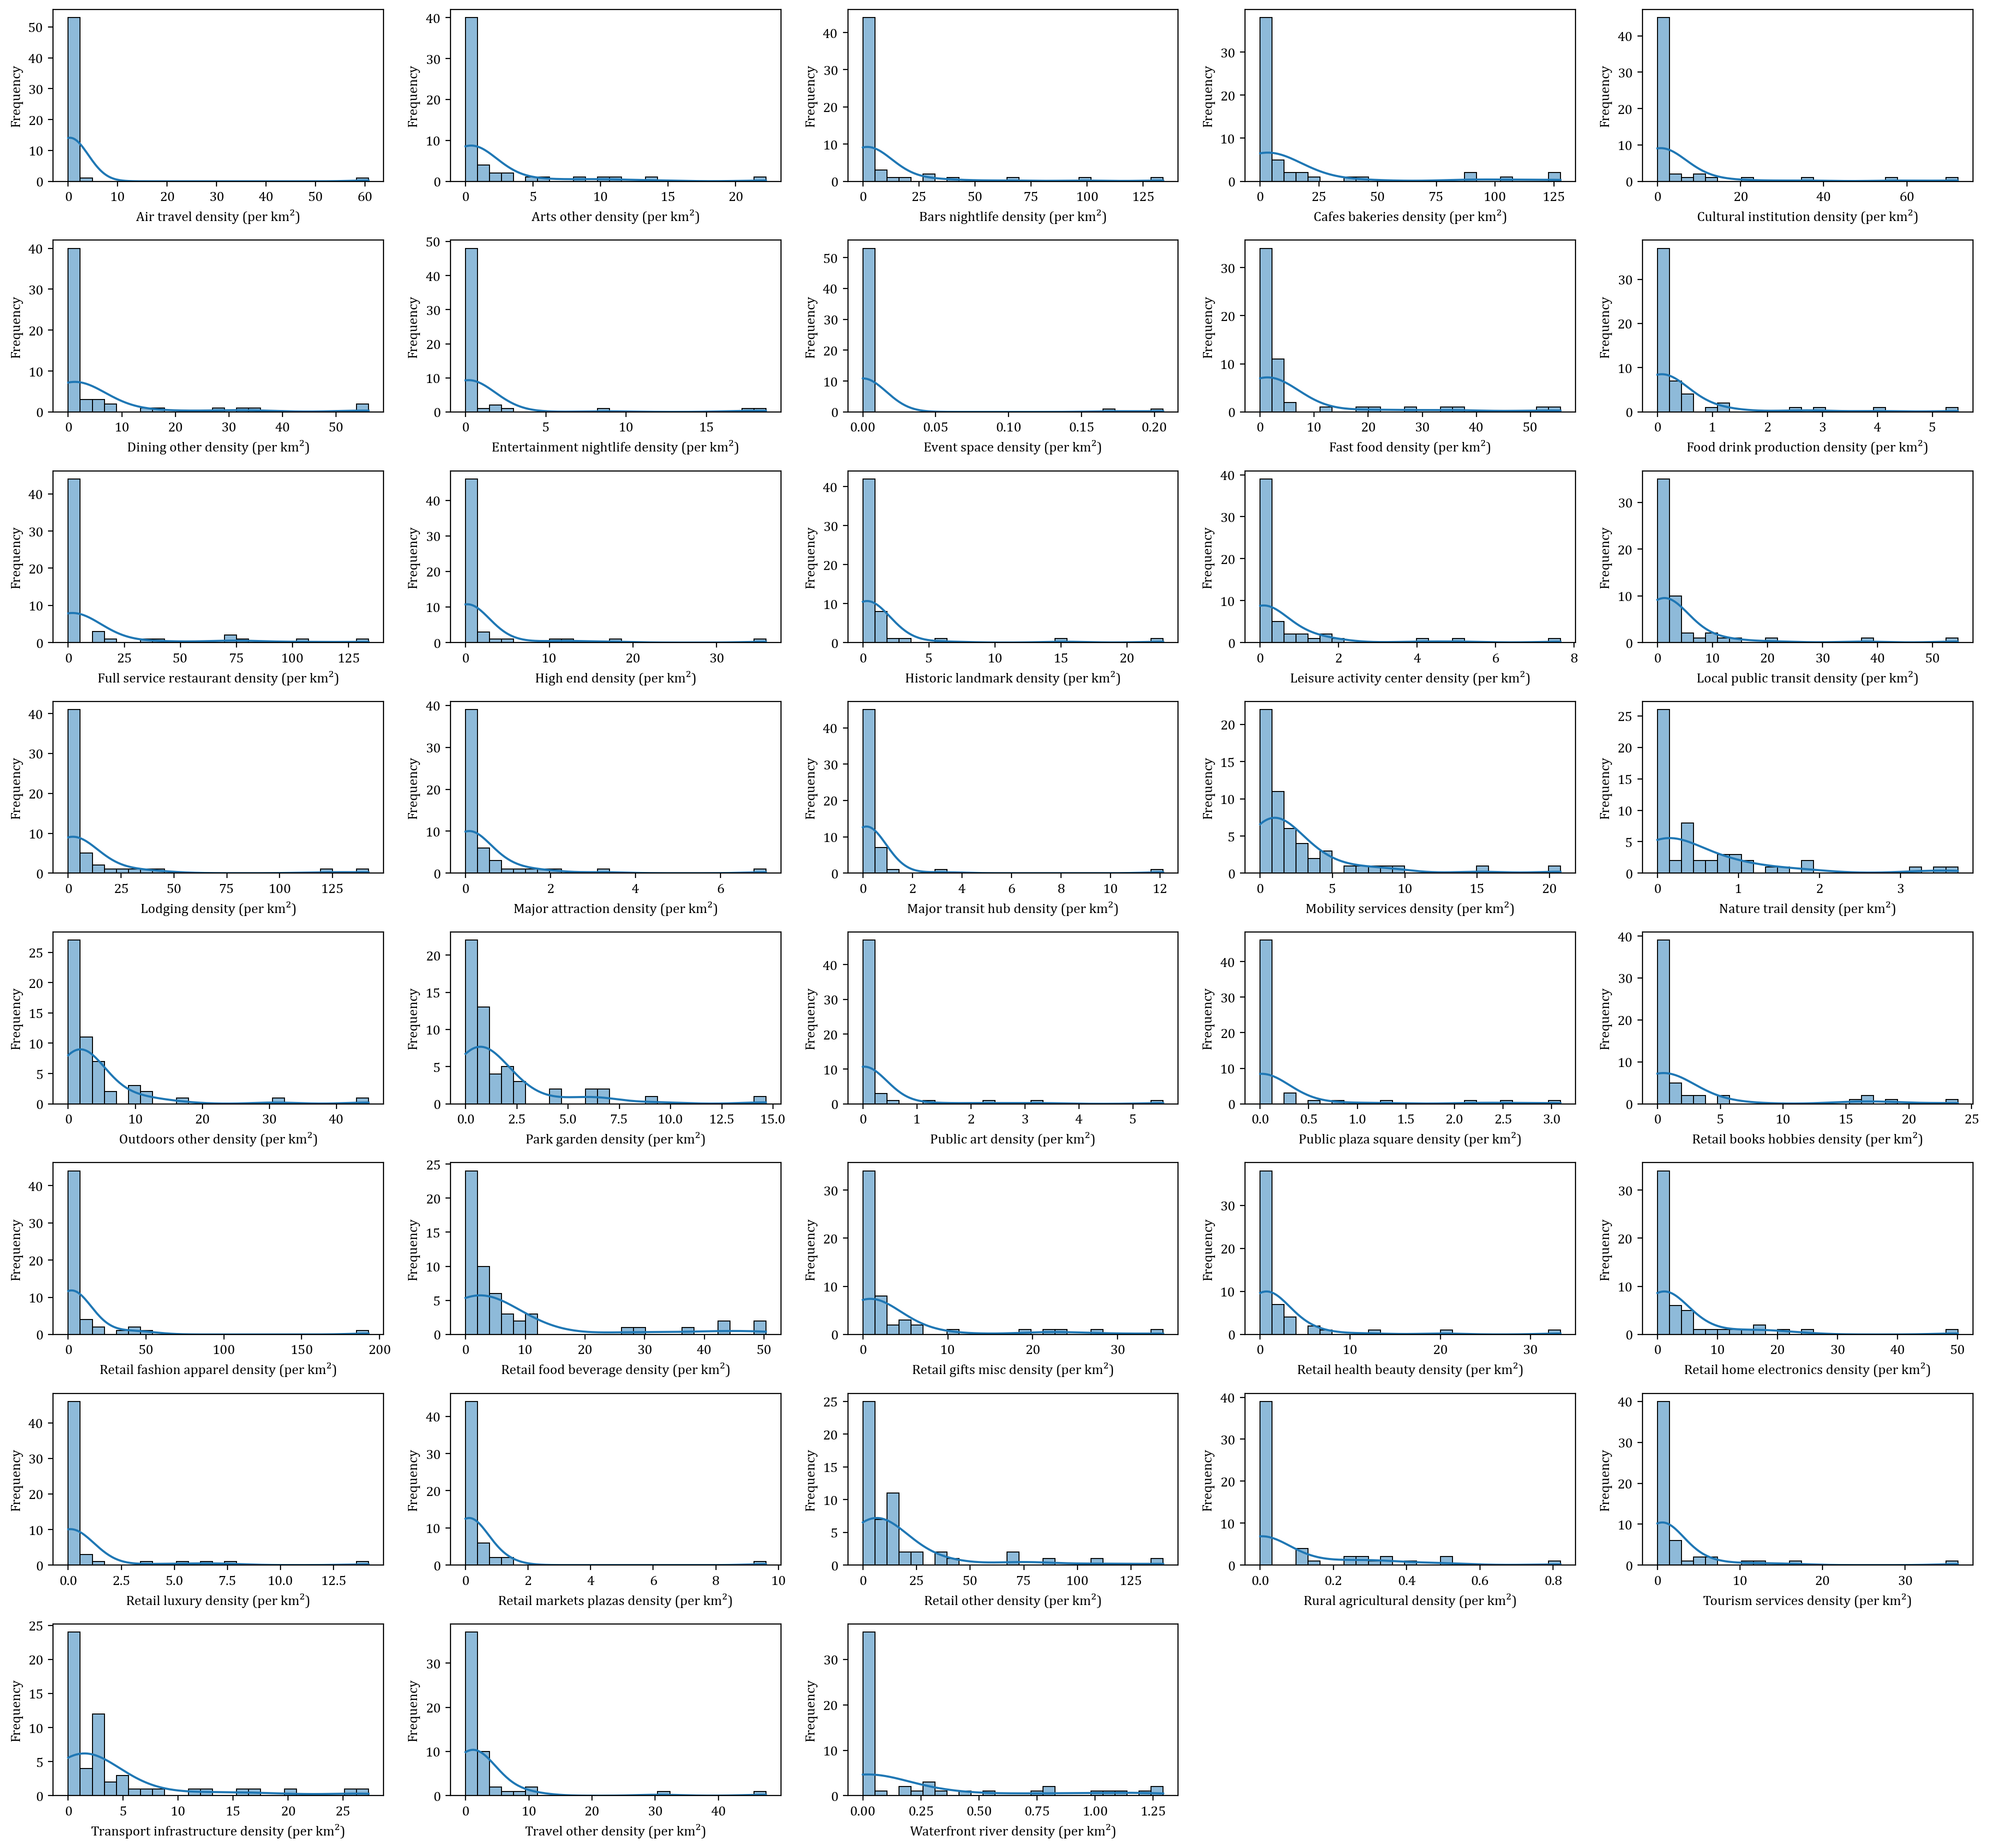

In [12]:
# For all features, create histograms to check for normality and put into a single figure and hide empty subplots
fig, axes = plt.subplots(14, 5, figsize=(20, 32))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=25, kde=True, ax=axes[i])
    axes[i].set_xlabel(axes[i].get_xlabel().replace('_', ' ').replace('density', 'Density (per km²)').capitalize(), fontproperties=cambria_prop)
    axes[i].set_ylabel('Frequency', fontproperties=cambria_prop)
    axes[i].grid(False)
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show();

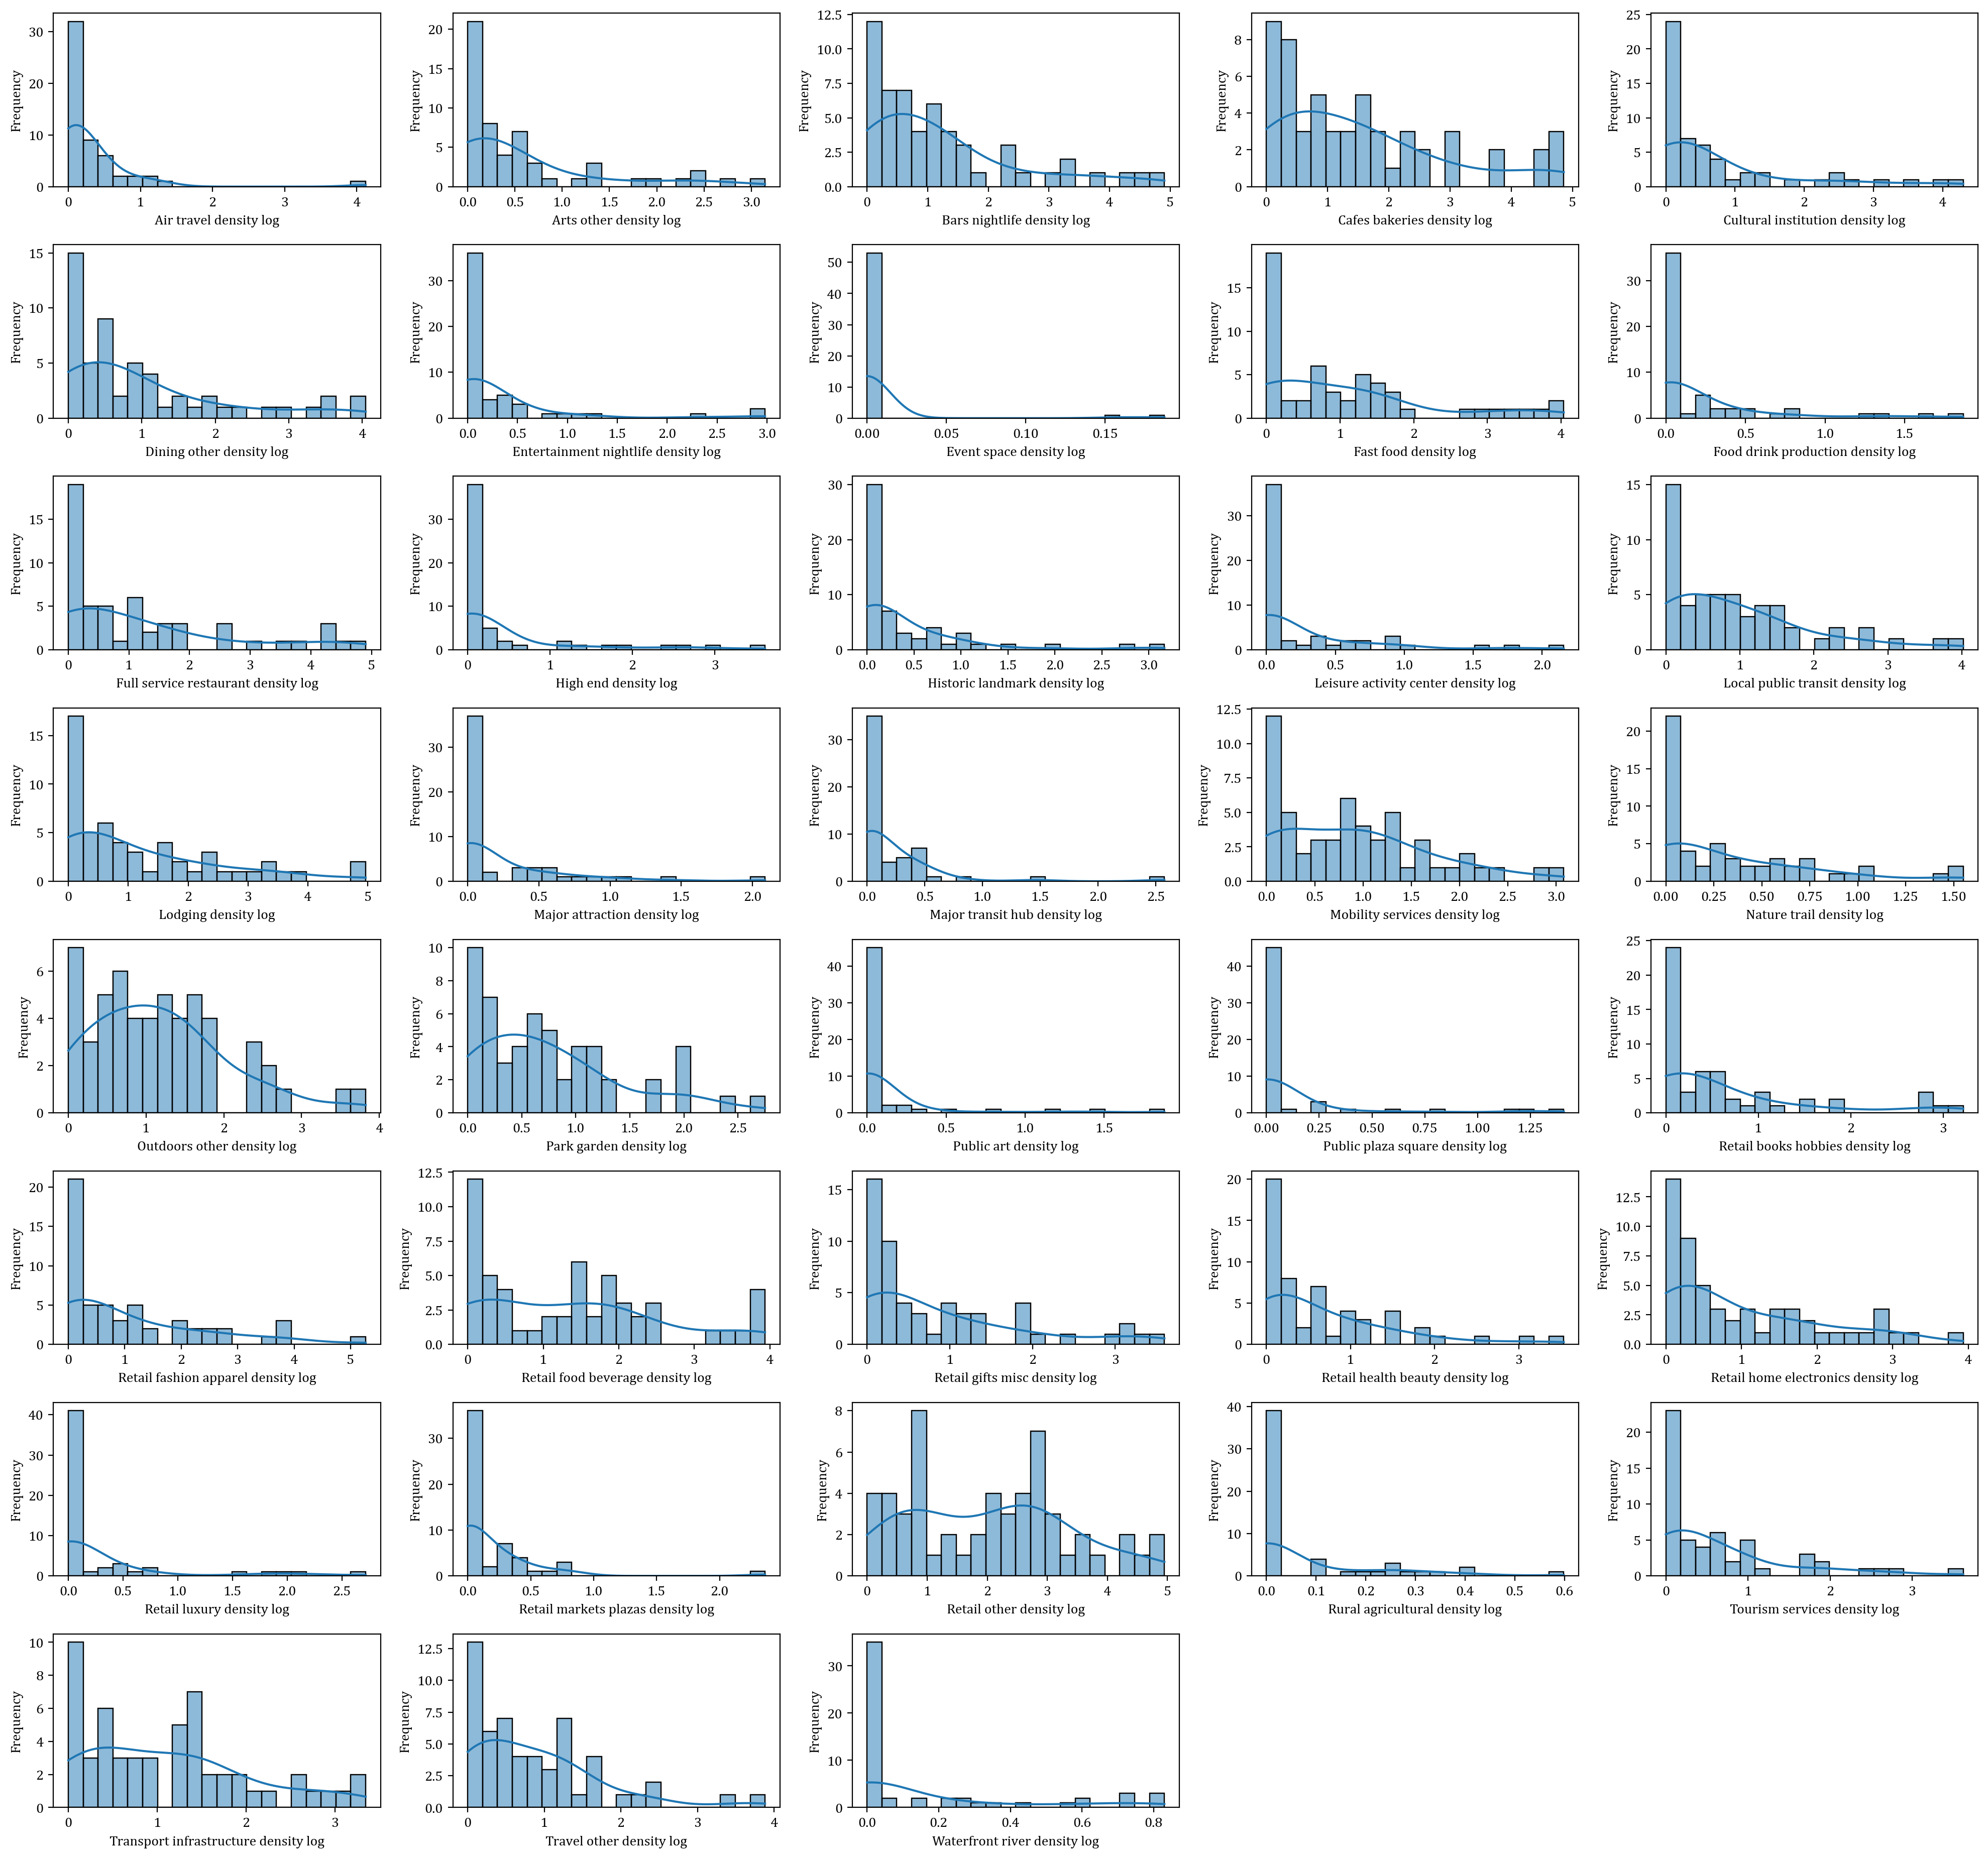

In [14]:
# For all features, create histograms to check for normality and put into a single figure and hide empty subplots
fig, axes = plt.subplots(14, 5, figsize=(20, 32))
axes = axes.flatten()
for i, feature in enumerate(features_logged):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(axes[i].get_xlabel().replace('_', ' ').replace('density_log', 'Density (per km²) (log)').capitalize(), fontproperties=cambria_prop)
    axes[i].set_ylabel('Frequency', fontproperties=cambria_prop)
    axes[i].grid(False)
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show();

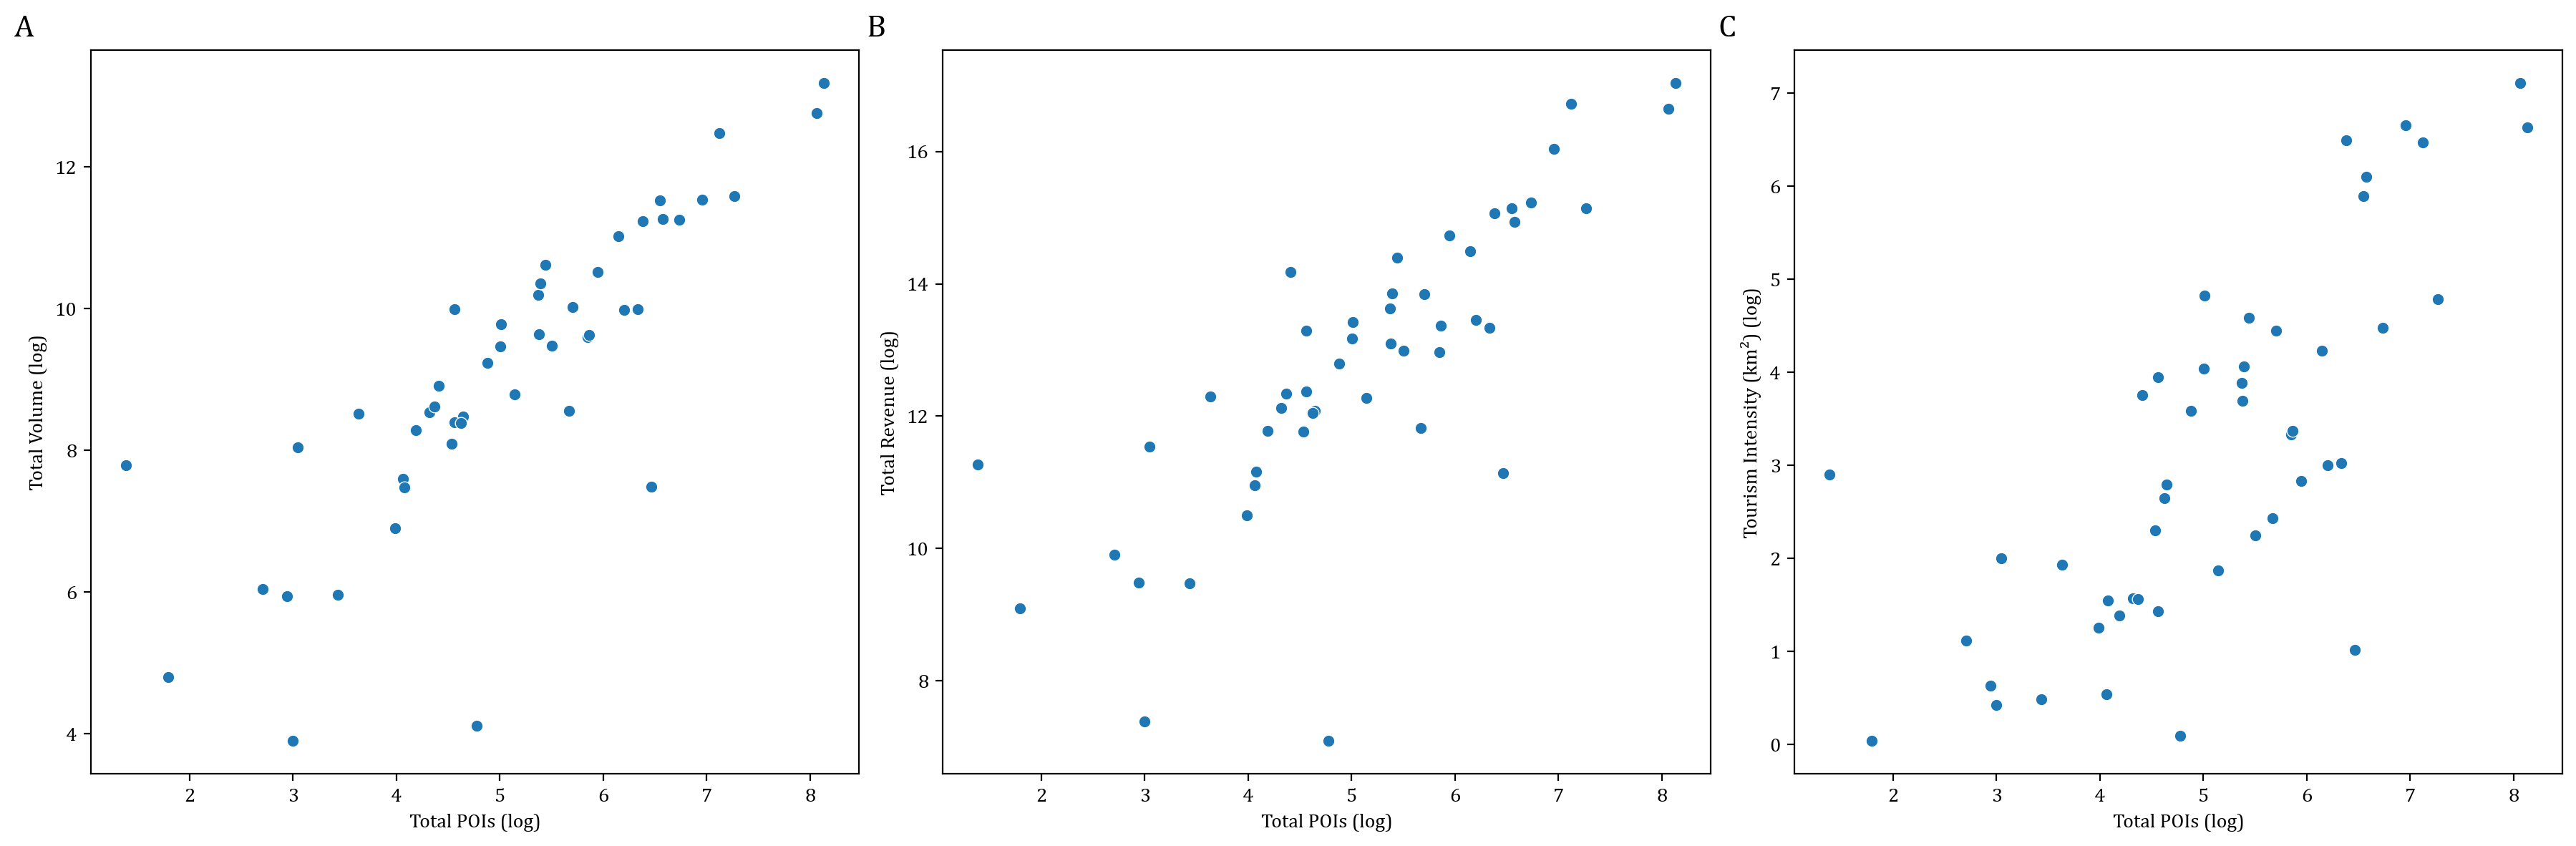

In [7]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_volume_log', ax=axes[0])
axes[0].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[0].set_ylabel('Total Volume (log)', fontproperties=cambria_prop)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_revenue_log', ax=axes[1])
axes[1].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[1].set_ylabel('Total Revenue (log)', fontproperties=cambria_prop)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[2].set_ylabel('Tourism Intensity (km²) (log)', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()


## 3. Random Forest
### Total Revenue

Analysing: Total Revenue ($)
Data prepared for target: 'total_revenue_log'
Number of features: 38
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.60
Baseline MAE (log): 1.388
Baseline RMSE (log): 1.527
Baseline MAE (original): 5,495,237.77
Baseline RMSE (original): 9,433,911.61

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 30}
Tuned R-squared (R²): 0.48
Tuned MAE (log): 1.559
Tuned RMSE (log): 1.734
Tuned MAE (original): 5,784,372.32
Tuned RMSE (original): 9,913,364.43


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


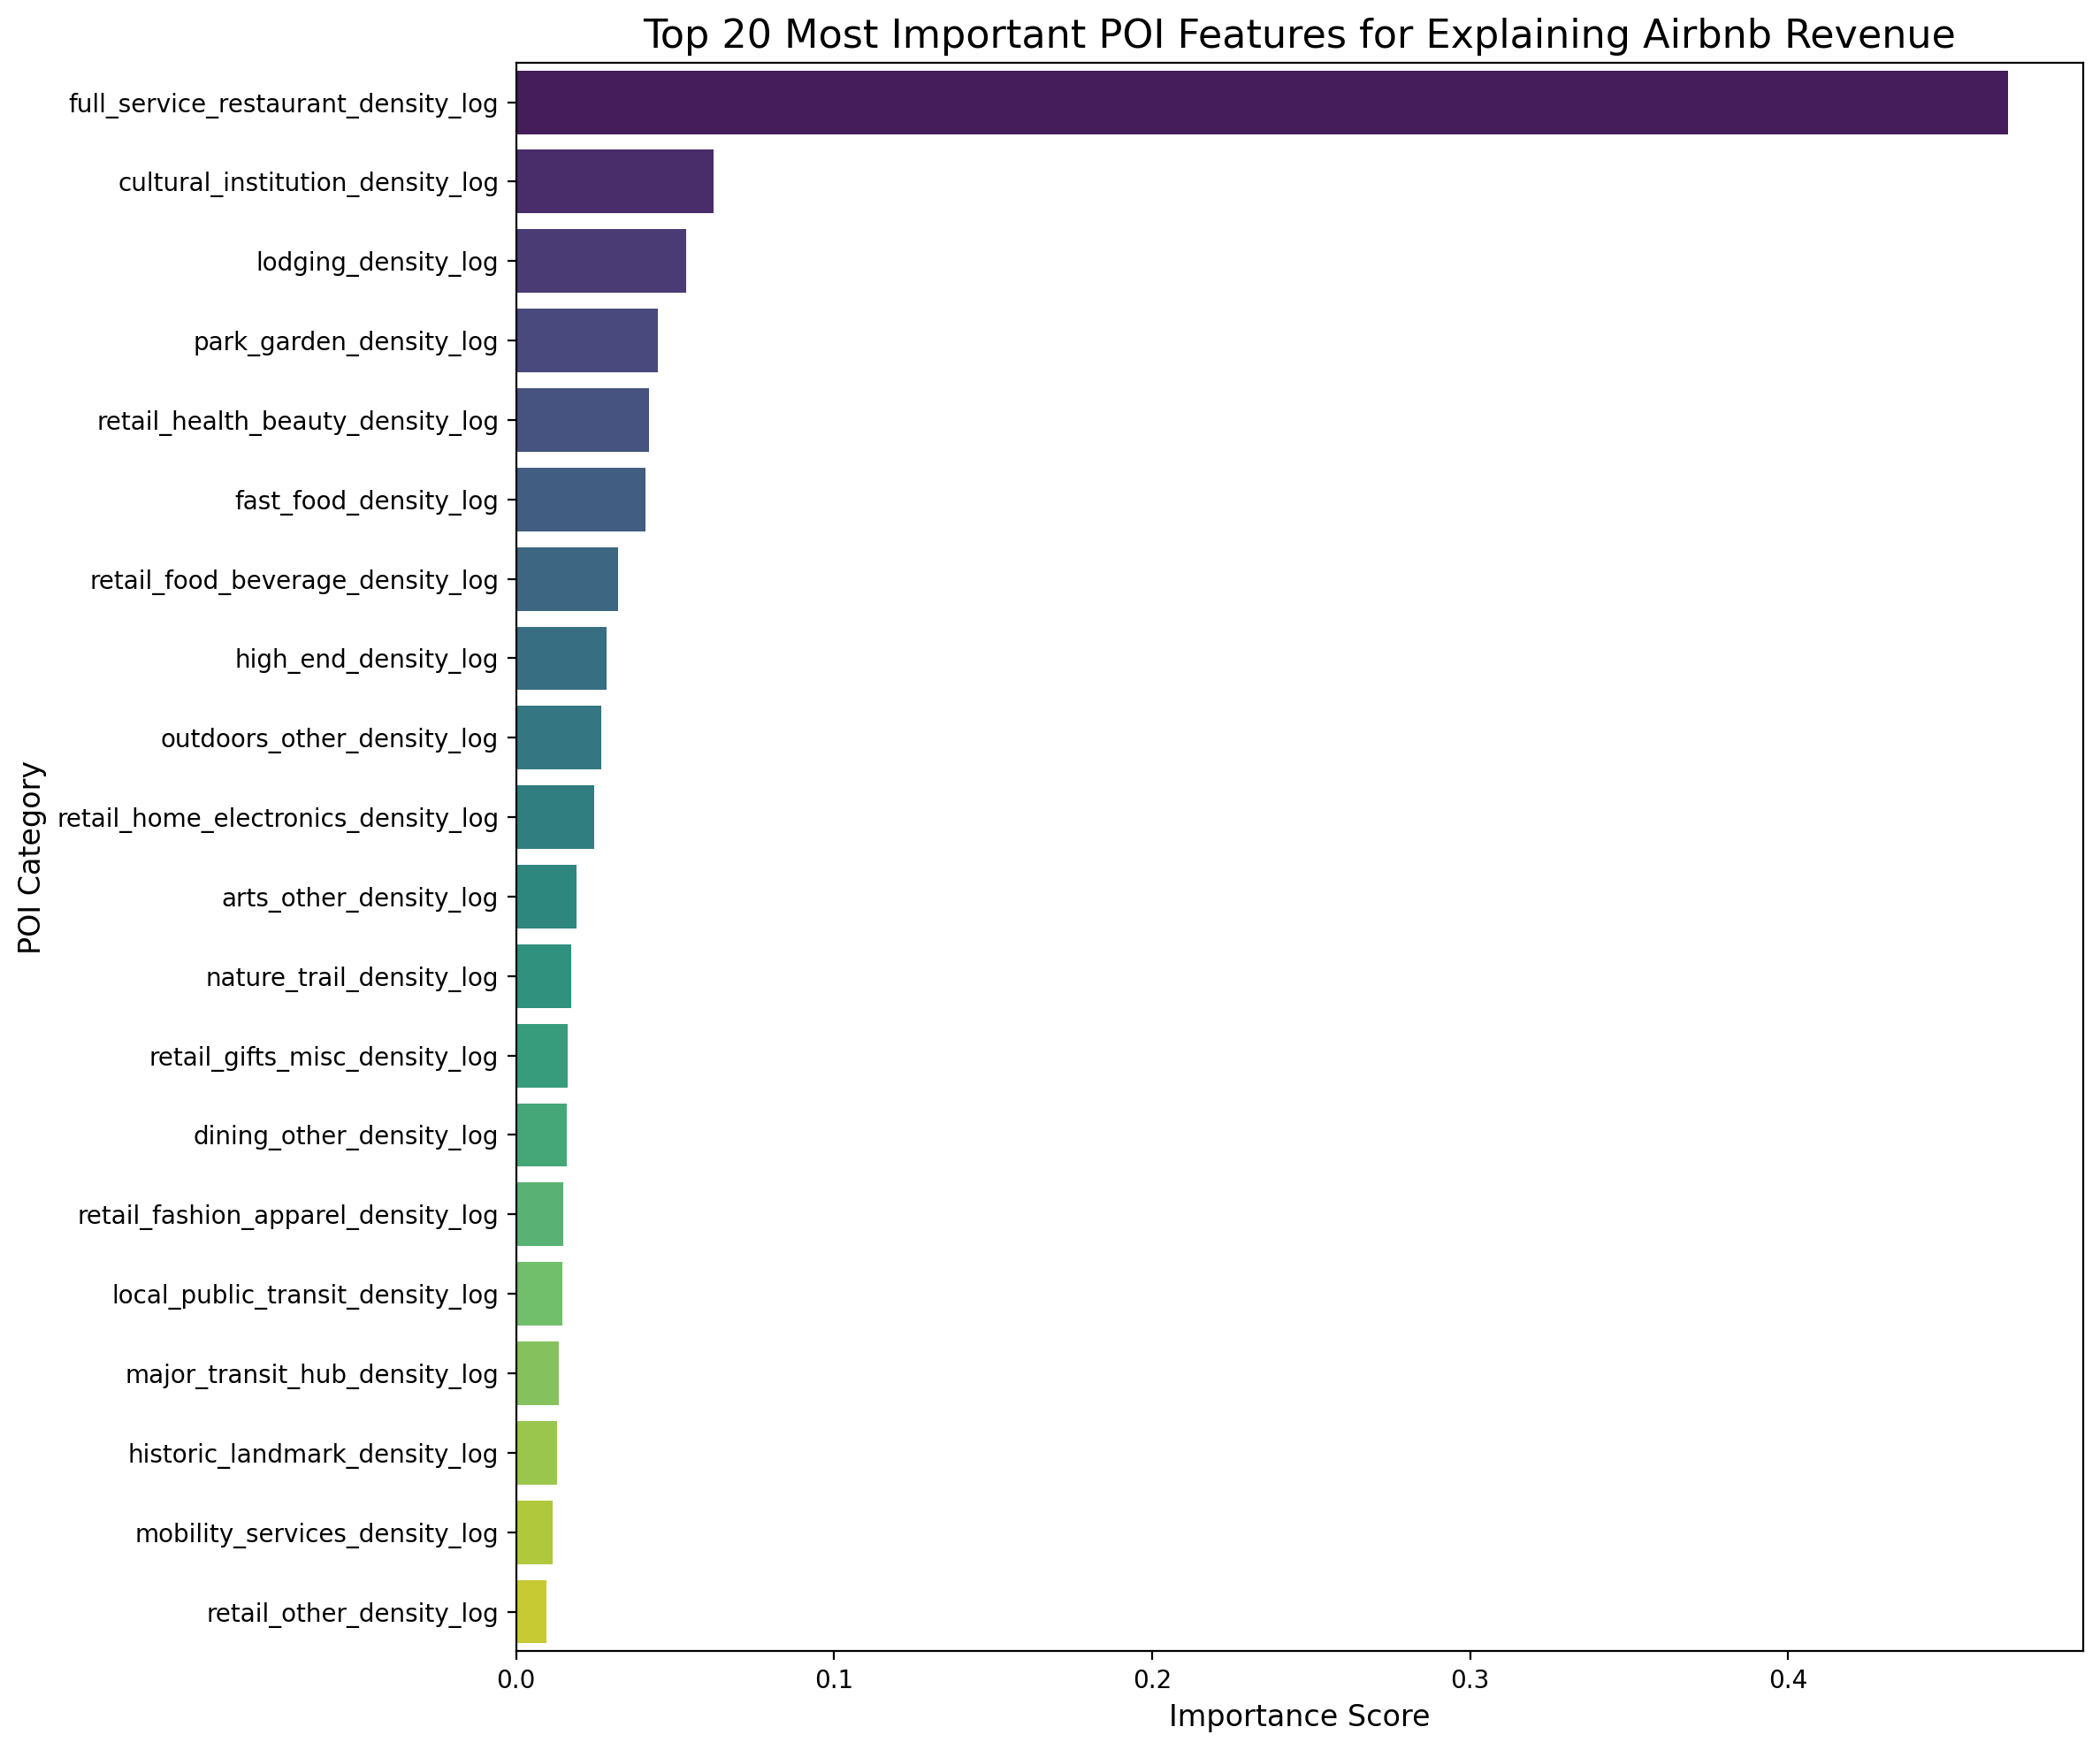


--- Top 10 Most Important Features ---
full_service_restaurant_density_log    0.469265
cultural_institution_density_log       0.062125
lodging_density_log                    0.053419
park_garden_density_log                0.044634
retail_health_beauty_density_log       0.041786
fast_food_density_log                  0.040676
retail_food_beverage_density_log       0.032017
high_end_density_log                   0.028394
outdoors_other_density_log             0.026842
retail_home_electronics_density_log    0.024544
dtype: float64


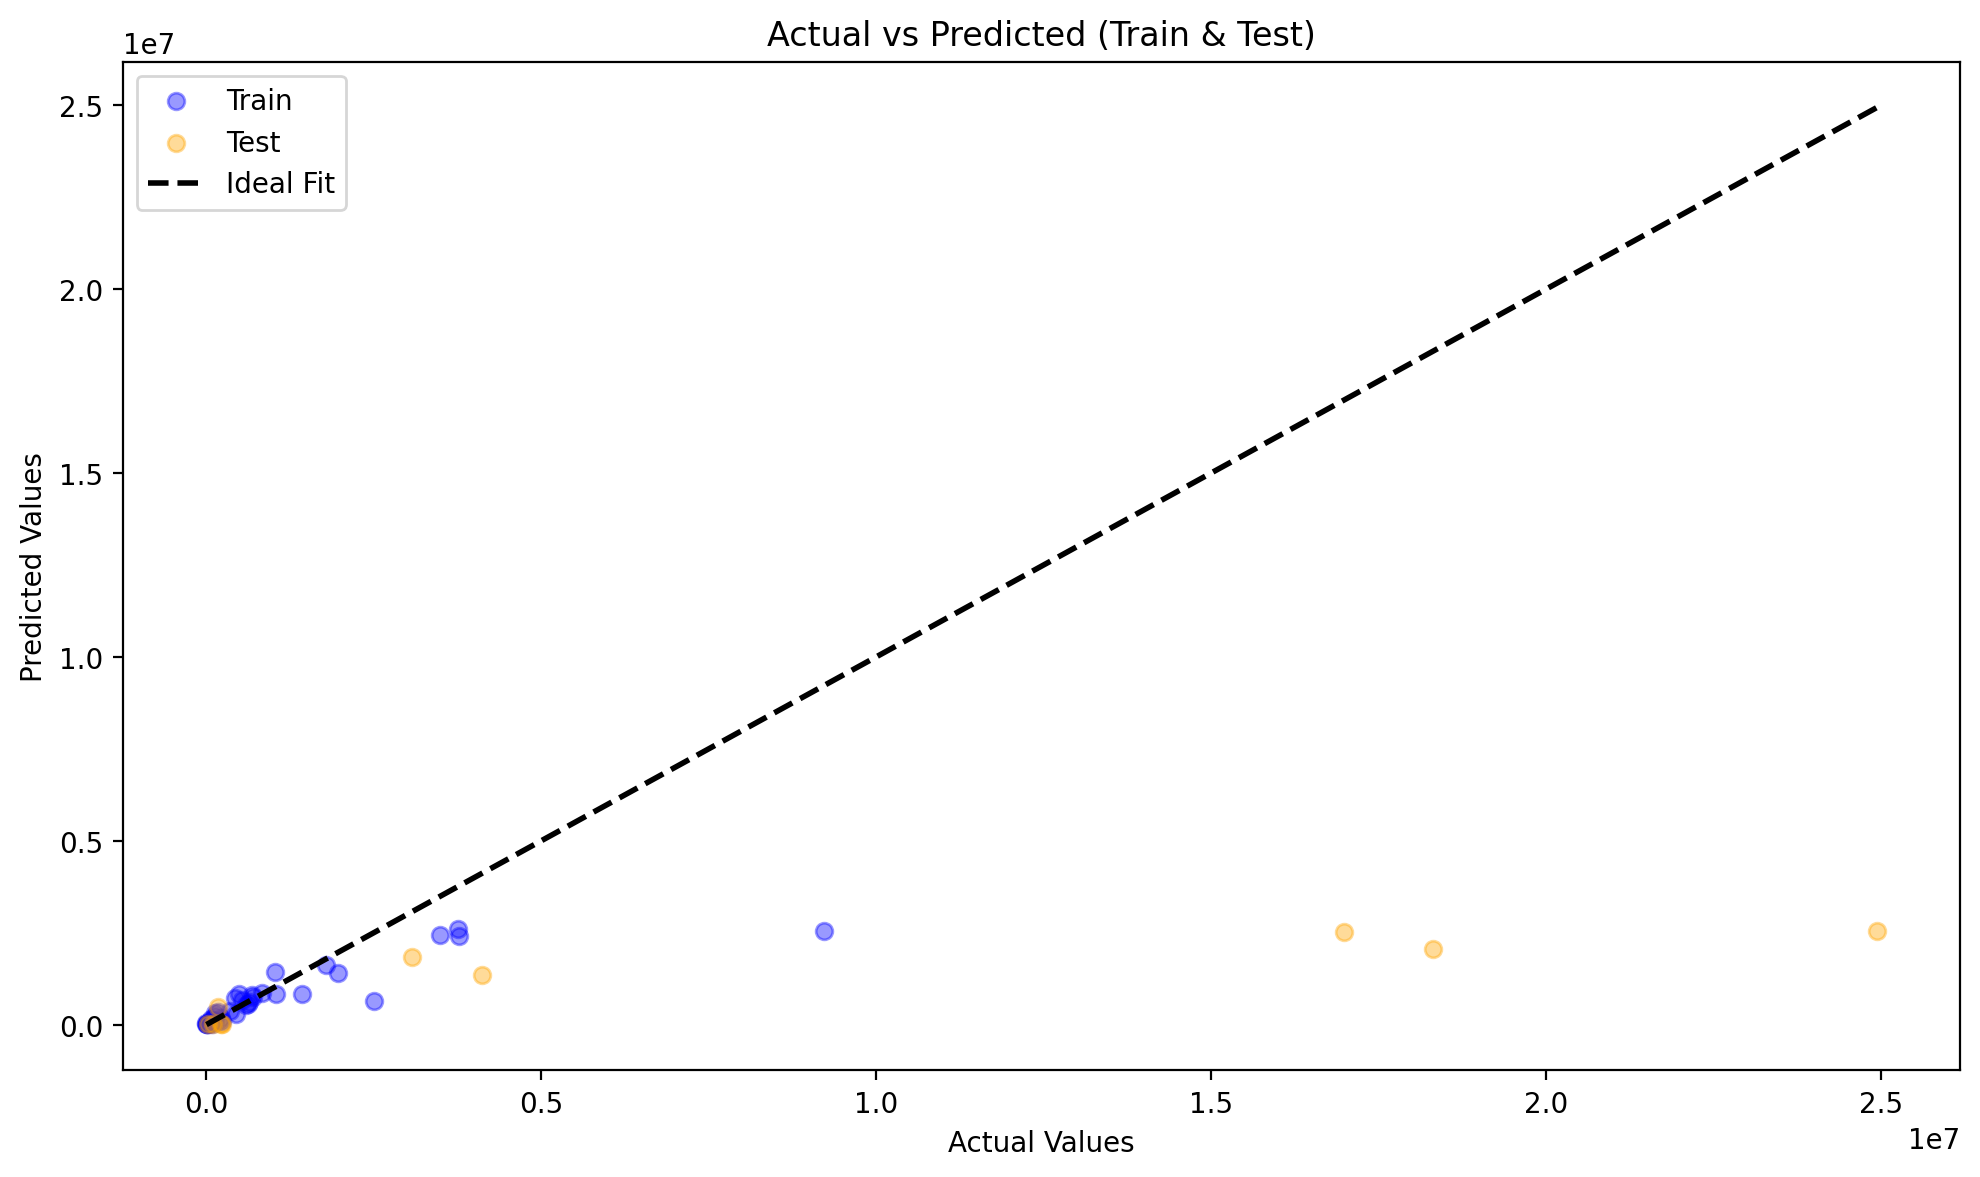

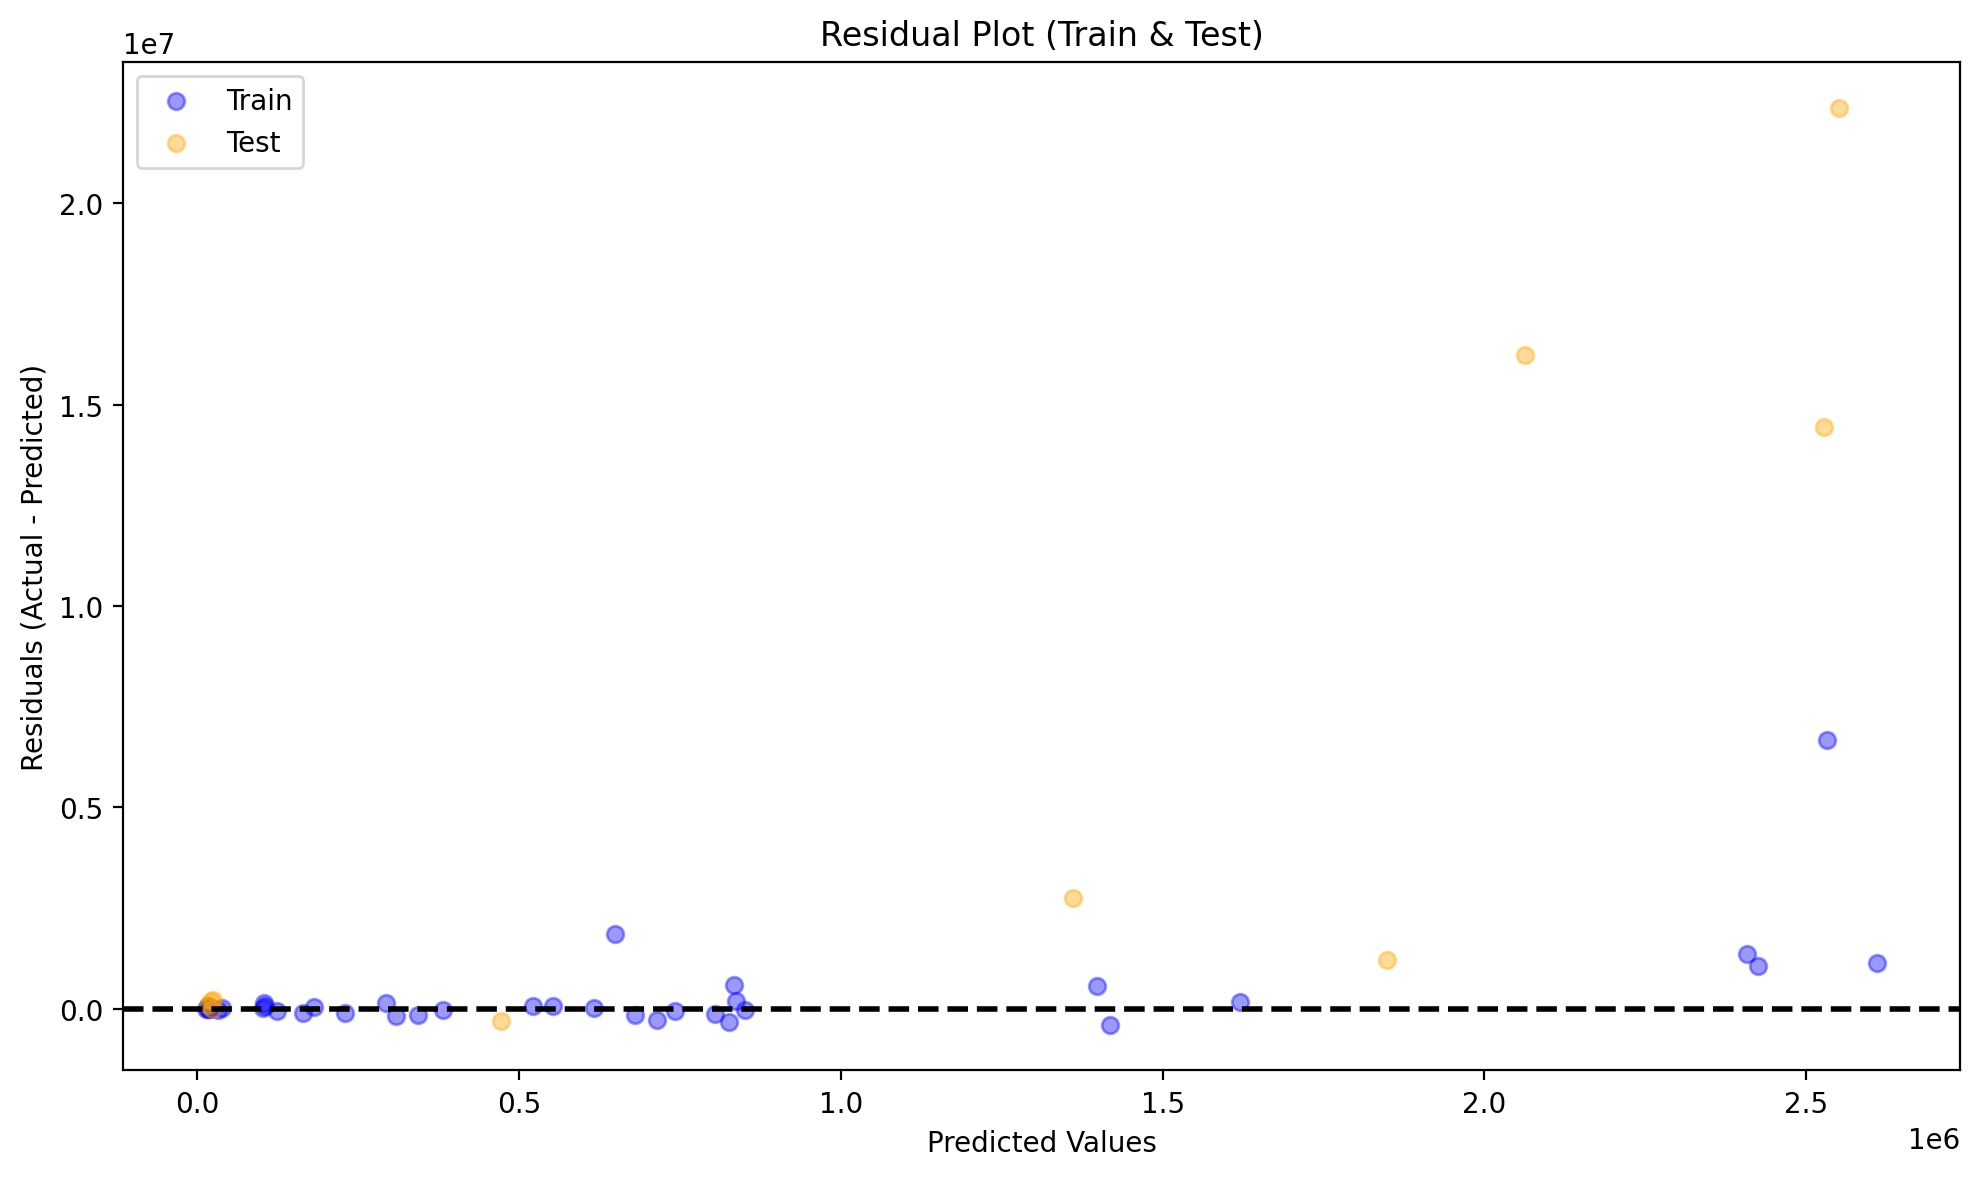

In [15]:
print("=" * 50)
print("Analysing: Total Revenue ($)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_revenue_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_revenue'])

### Total Volume

Analysing: Total Volume (number of guests)
Data prepared for target: 'total_volume_log'
Number of features: 38
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.62
Baseline MAE (log): 1.279
Baseline RMSE (log): 1.415
Baseline MAE (original): 99,079.55
Baseline RMSE (original): 175,104.27

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None}
Tuned R-squared (R²): 0.50
Tuned MAE (log): 1.497
Tuned RMSE (log): 1.638
Tuned MAE (original): 107,642.65
Tuned RMSE (original): 188,574.35


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


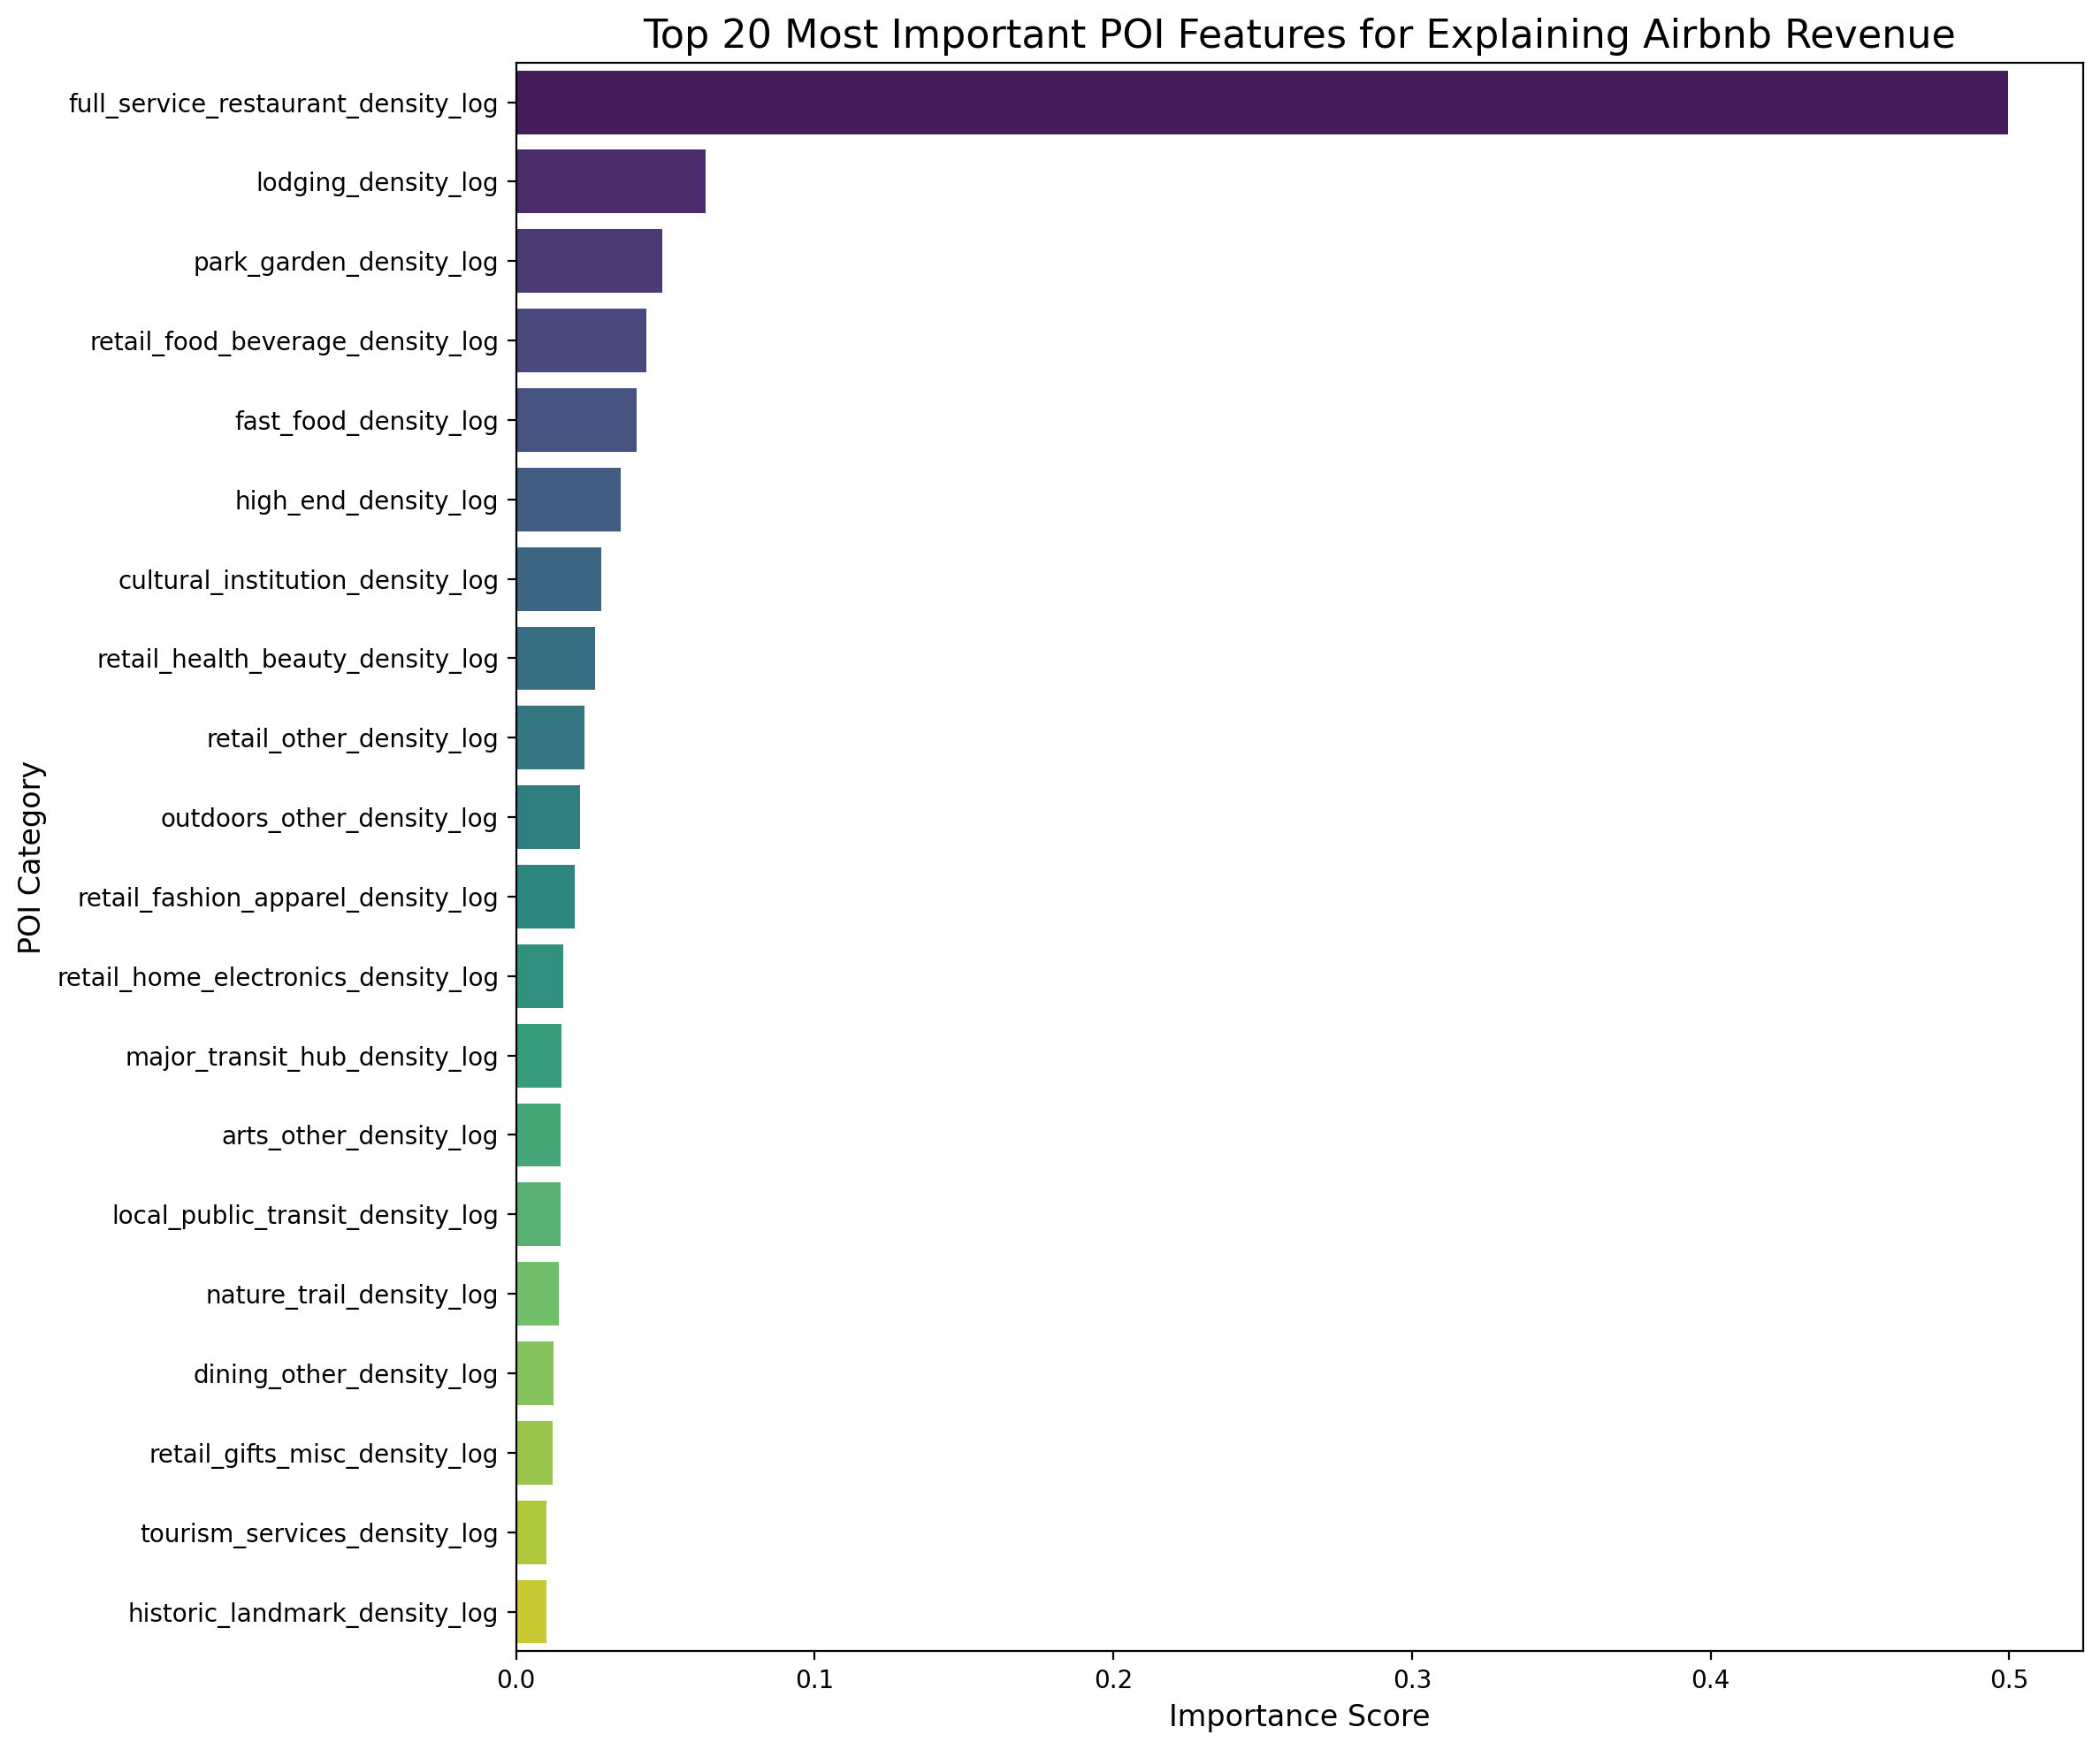


--- Top 10 Most Important Features ---
full_service_restaurant_density_log    0.499762
lodging_density_log                    0.063355
park_garden_density_log                0.048964
retail_food_beverage_density_log       0.043730
fast_food_density_log                  0.040323
high_end_density_log                   0.034960
cultural_institution_density_log       0.028529
retail_health_beauty_density_log       0.026424
retail_other_density_log               0.022832
outdoors_other_density_log             0.021450
dtype: float64


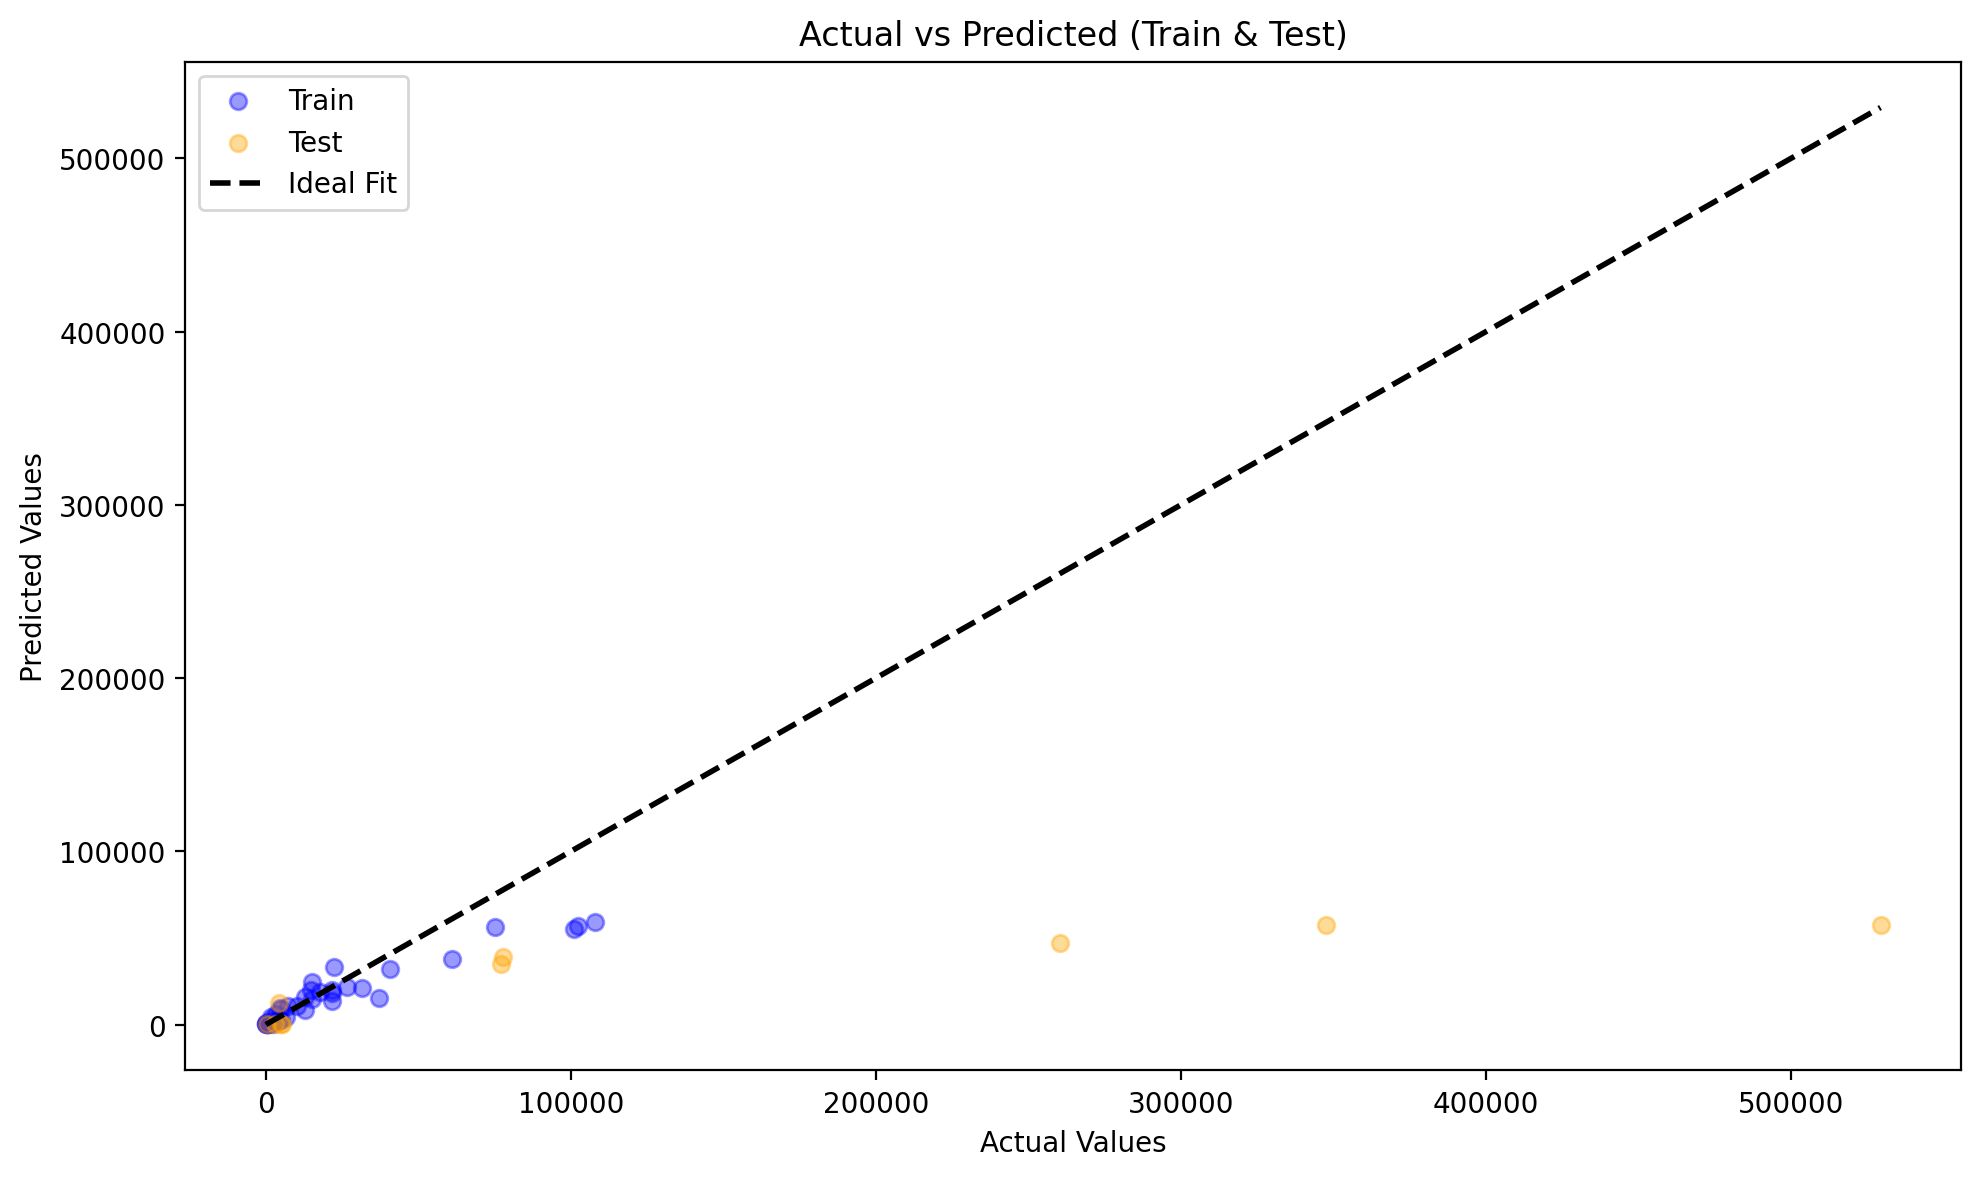

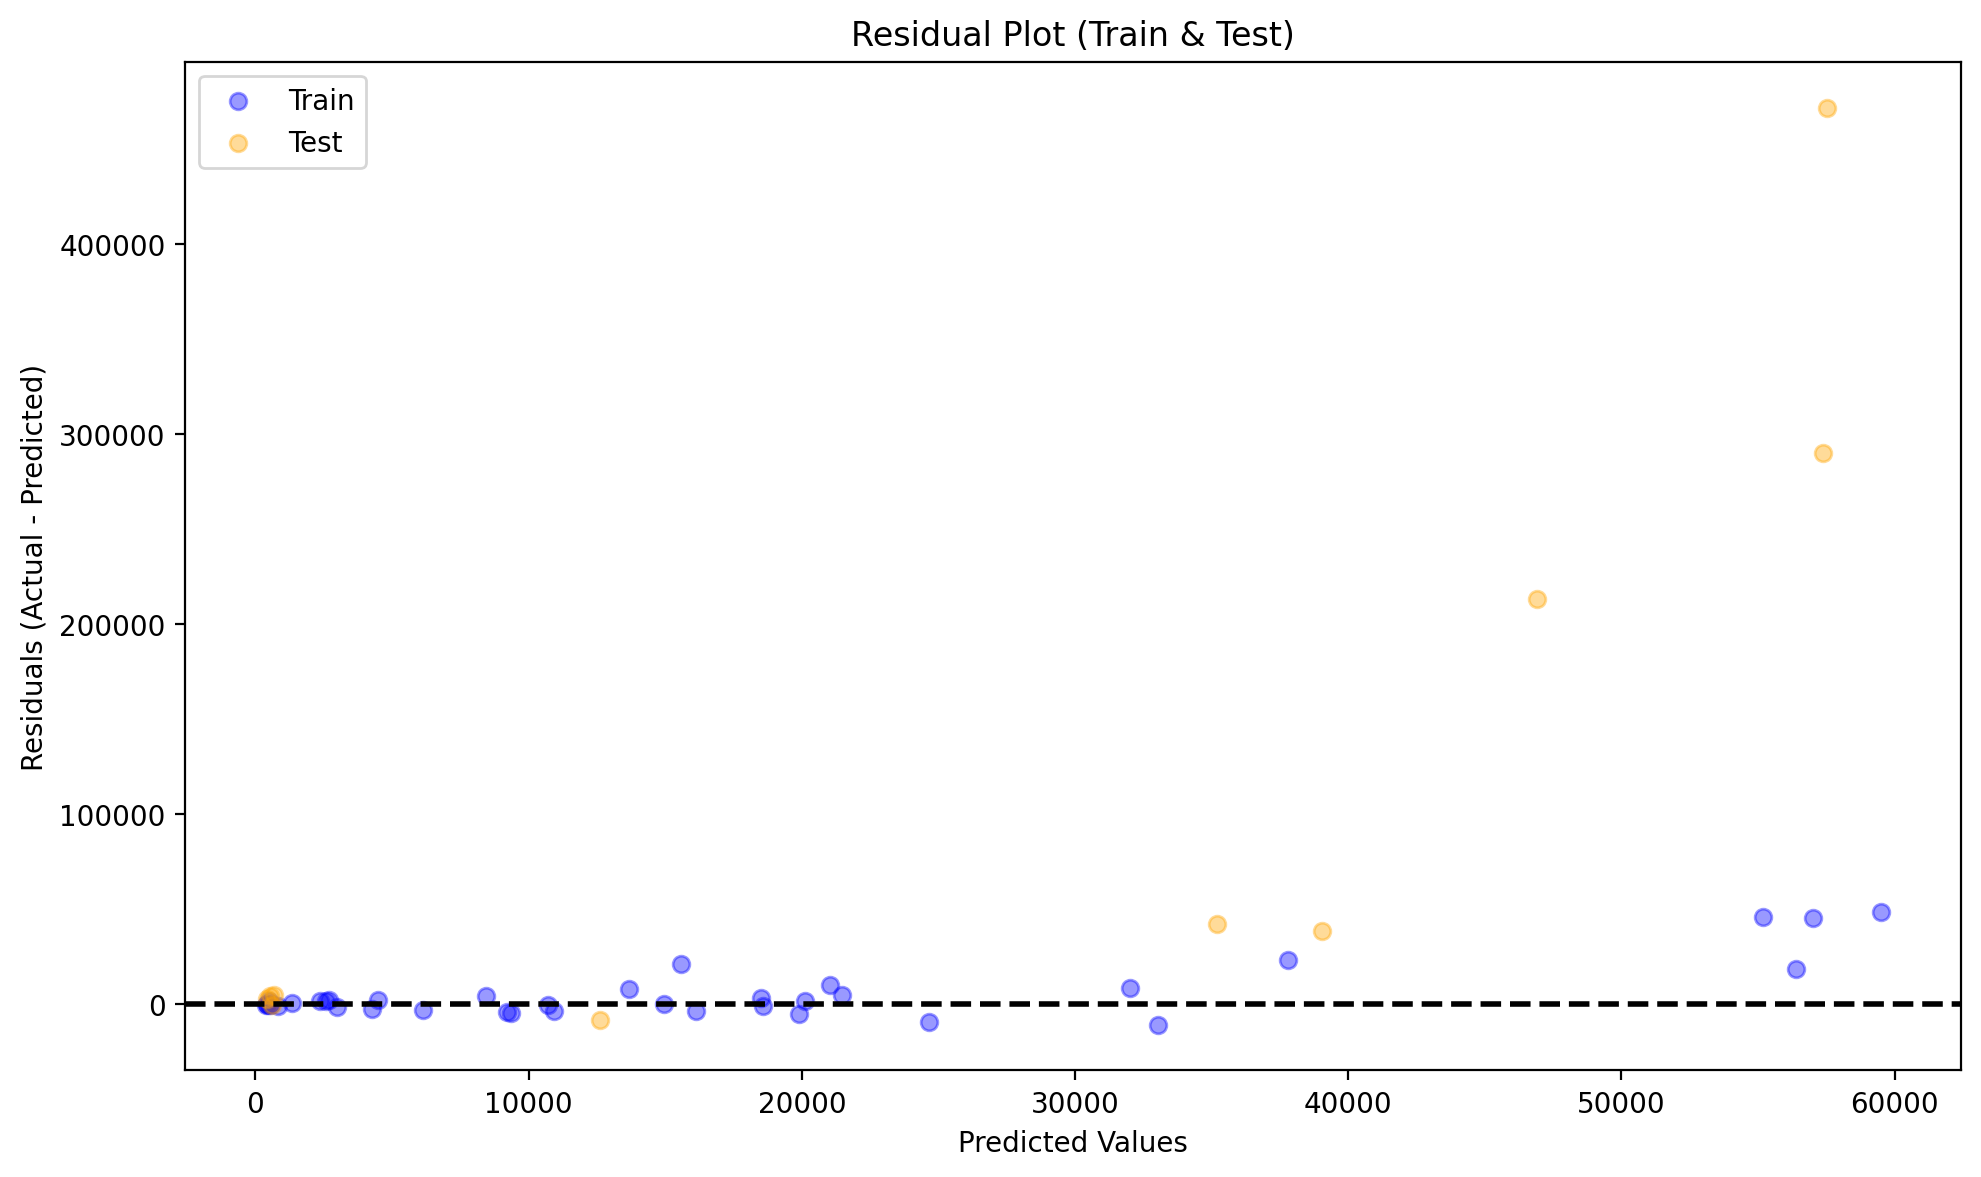

In [16]:
print("=" * 50)
print("Analysing: Total Volume (number of guests)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_volume_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_volume'])

### Guest Density

Analysing: Total Guest Density (Number of guestes per km2)
Data prepared for target: 'total_tourism_intensity_km2_log'
Number of features: 38
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.88
Baseline MAE (log): 0.685
Baseline RMSE (log): 0.798
Baseline MAE (original): 164.97
Baseline RMSE (original): 276.78

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20}
Tuned R-squared (R²): 0.87
Tuned MAE (log): 0.711
Tuned RMSE (log): 0.810
Tuned MAE (original): 183.18
Tuned RMSE (original): 320.65


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


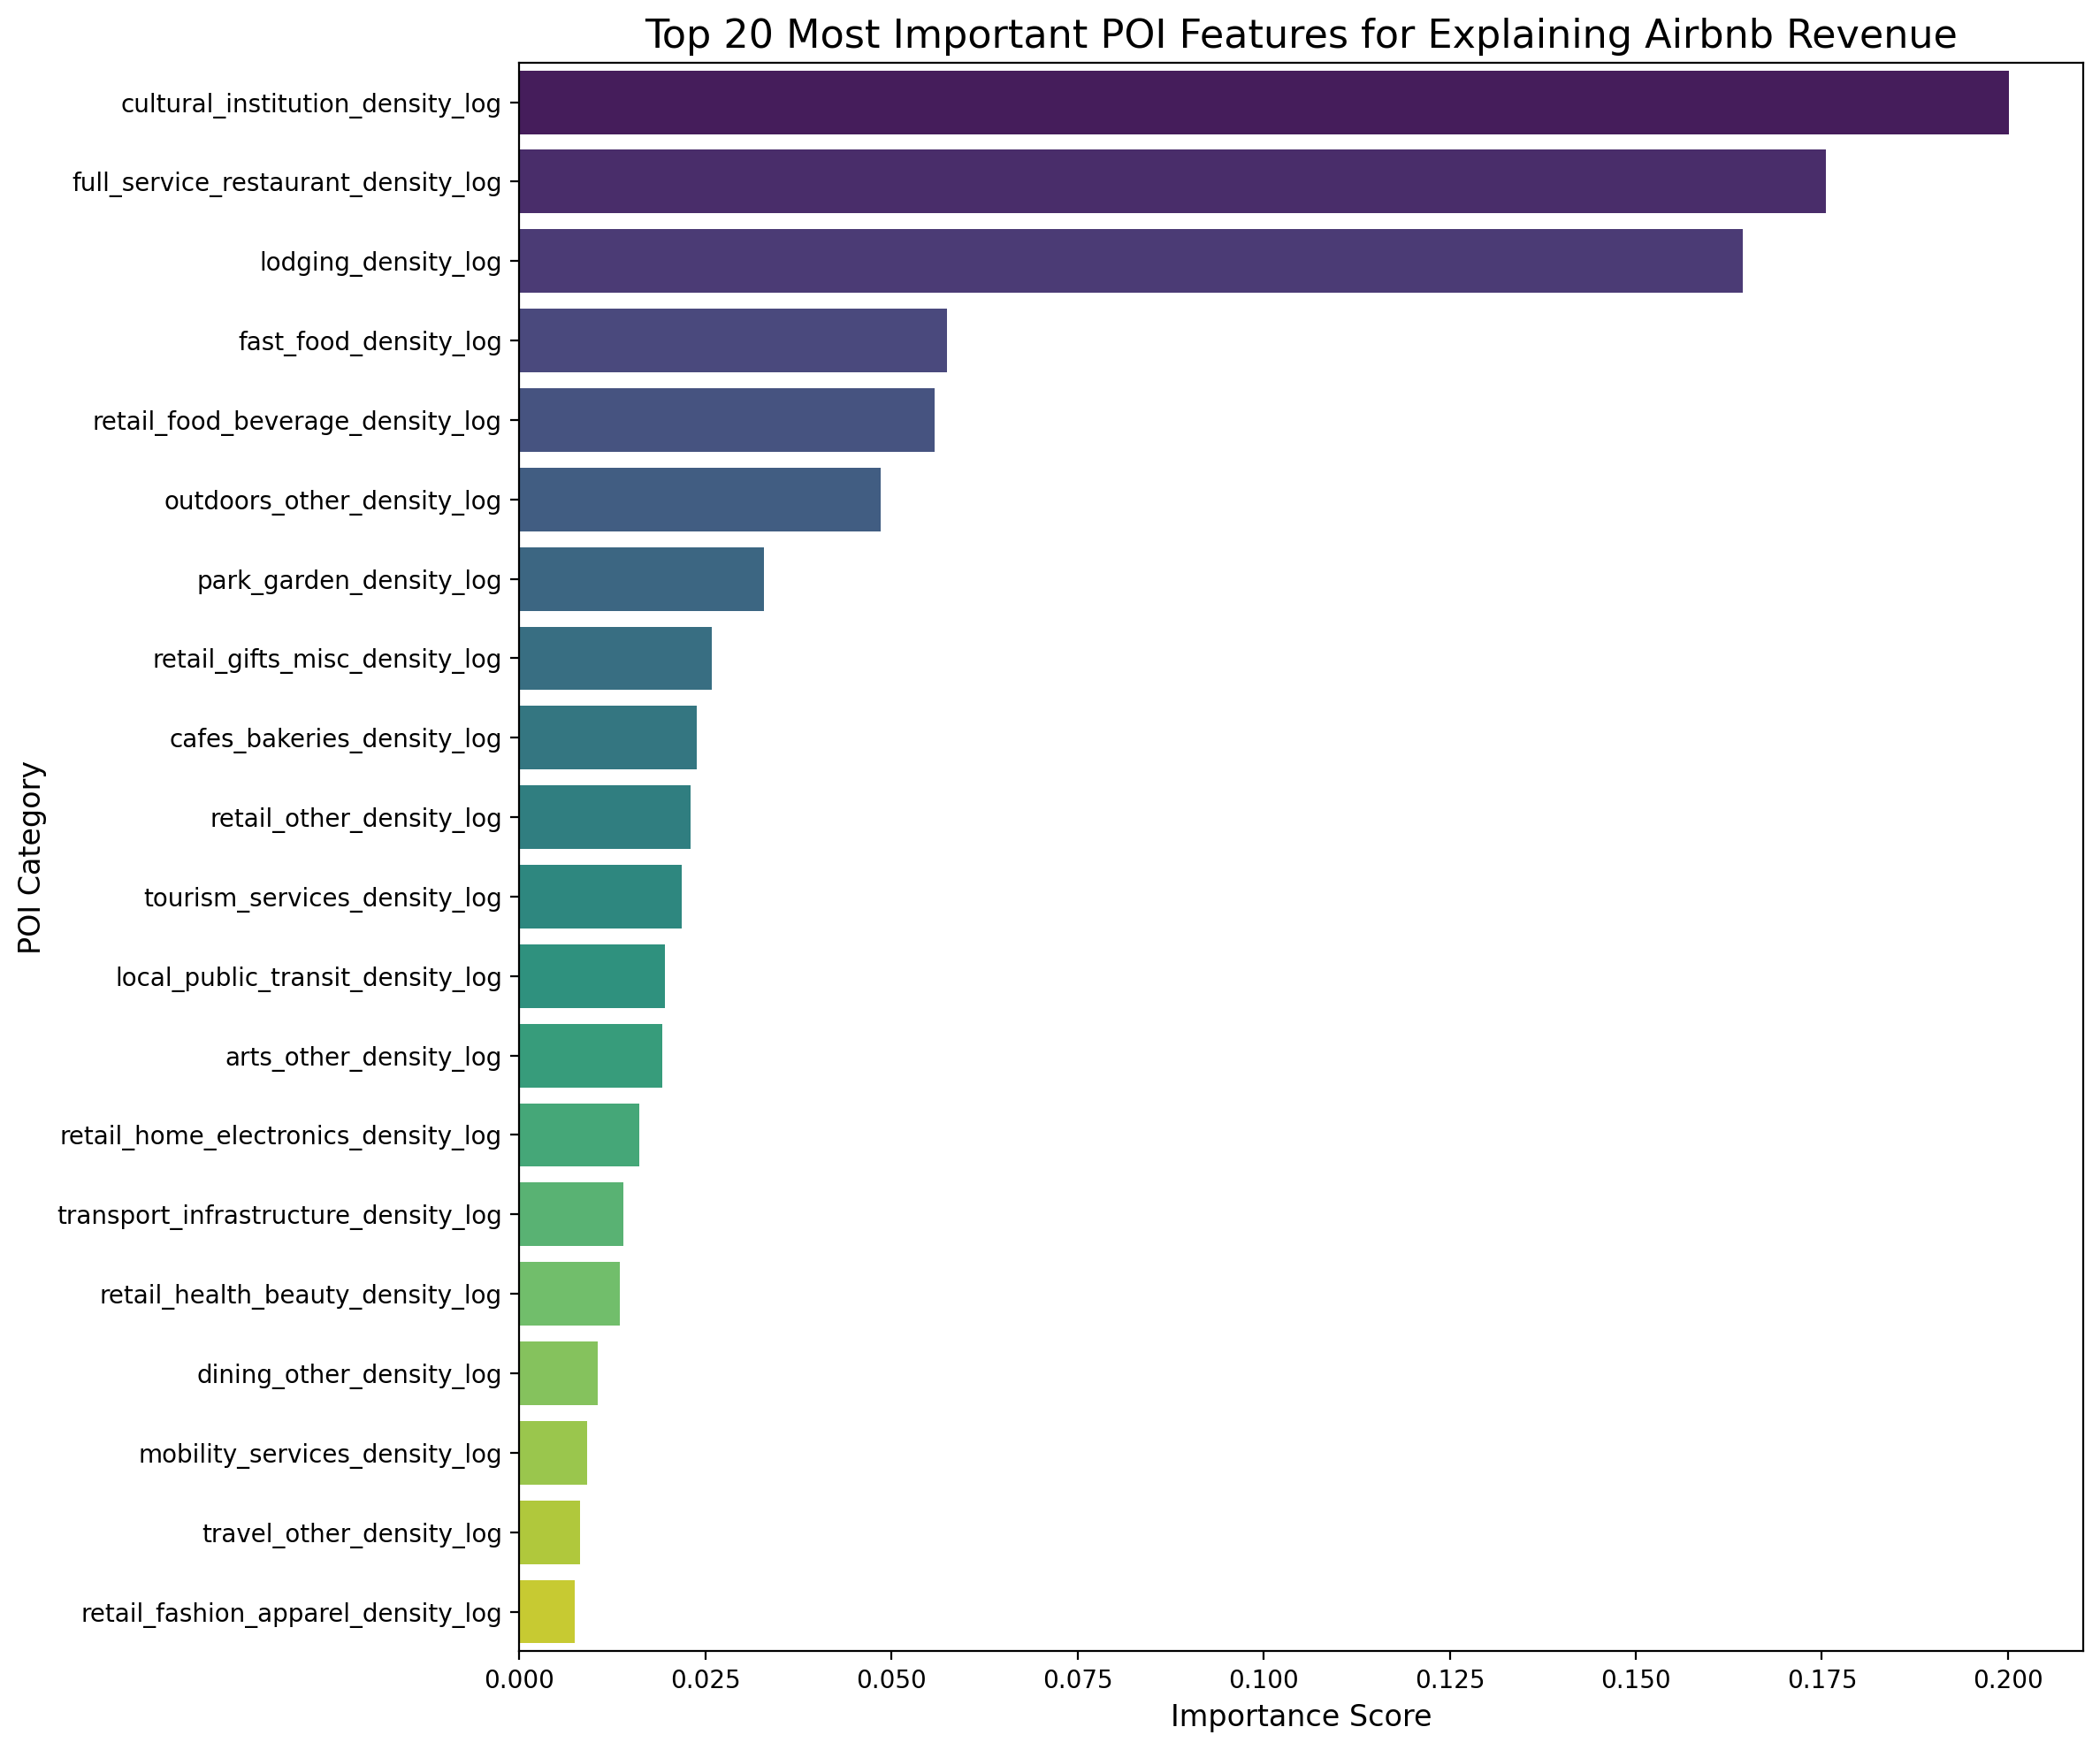


--- Top 10 Most Important Features ---
cultural_institution_density_log       0.200071
full_service_restaurant_density_log    0.175519
lodging_density_log                    0.164325
fast_food_density_log                  0.057413
retail_food_beverage_density_log       0.055854
outdoors_other_density_log             0.048502
park_garden_density_log                0.032863
retail_gifts_misc_density_log          0.025827
cafes_bakeries_density_log             0.023833
retail_other_density_log               0.023003
dtype: float64


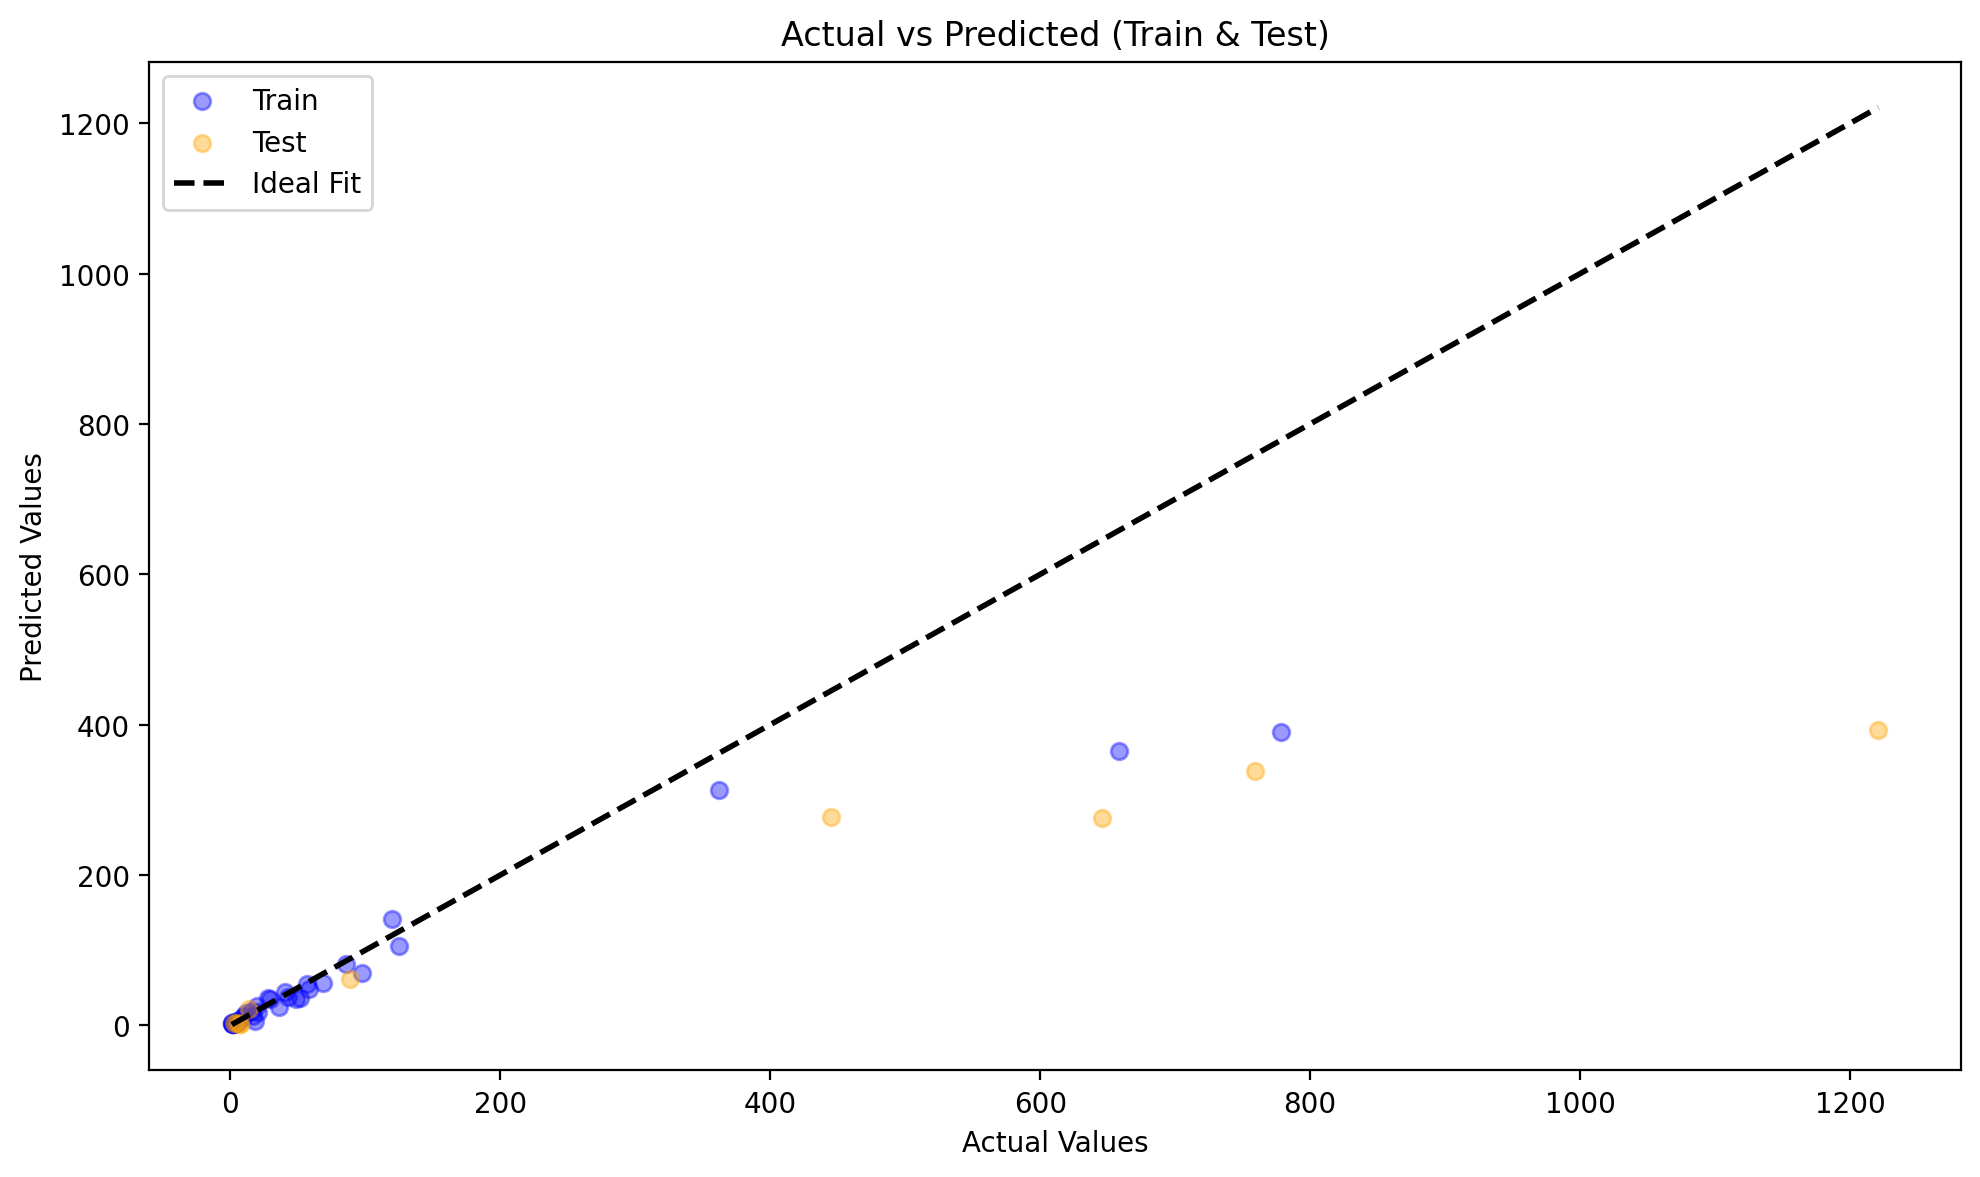

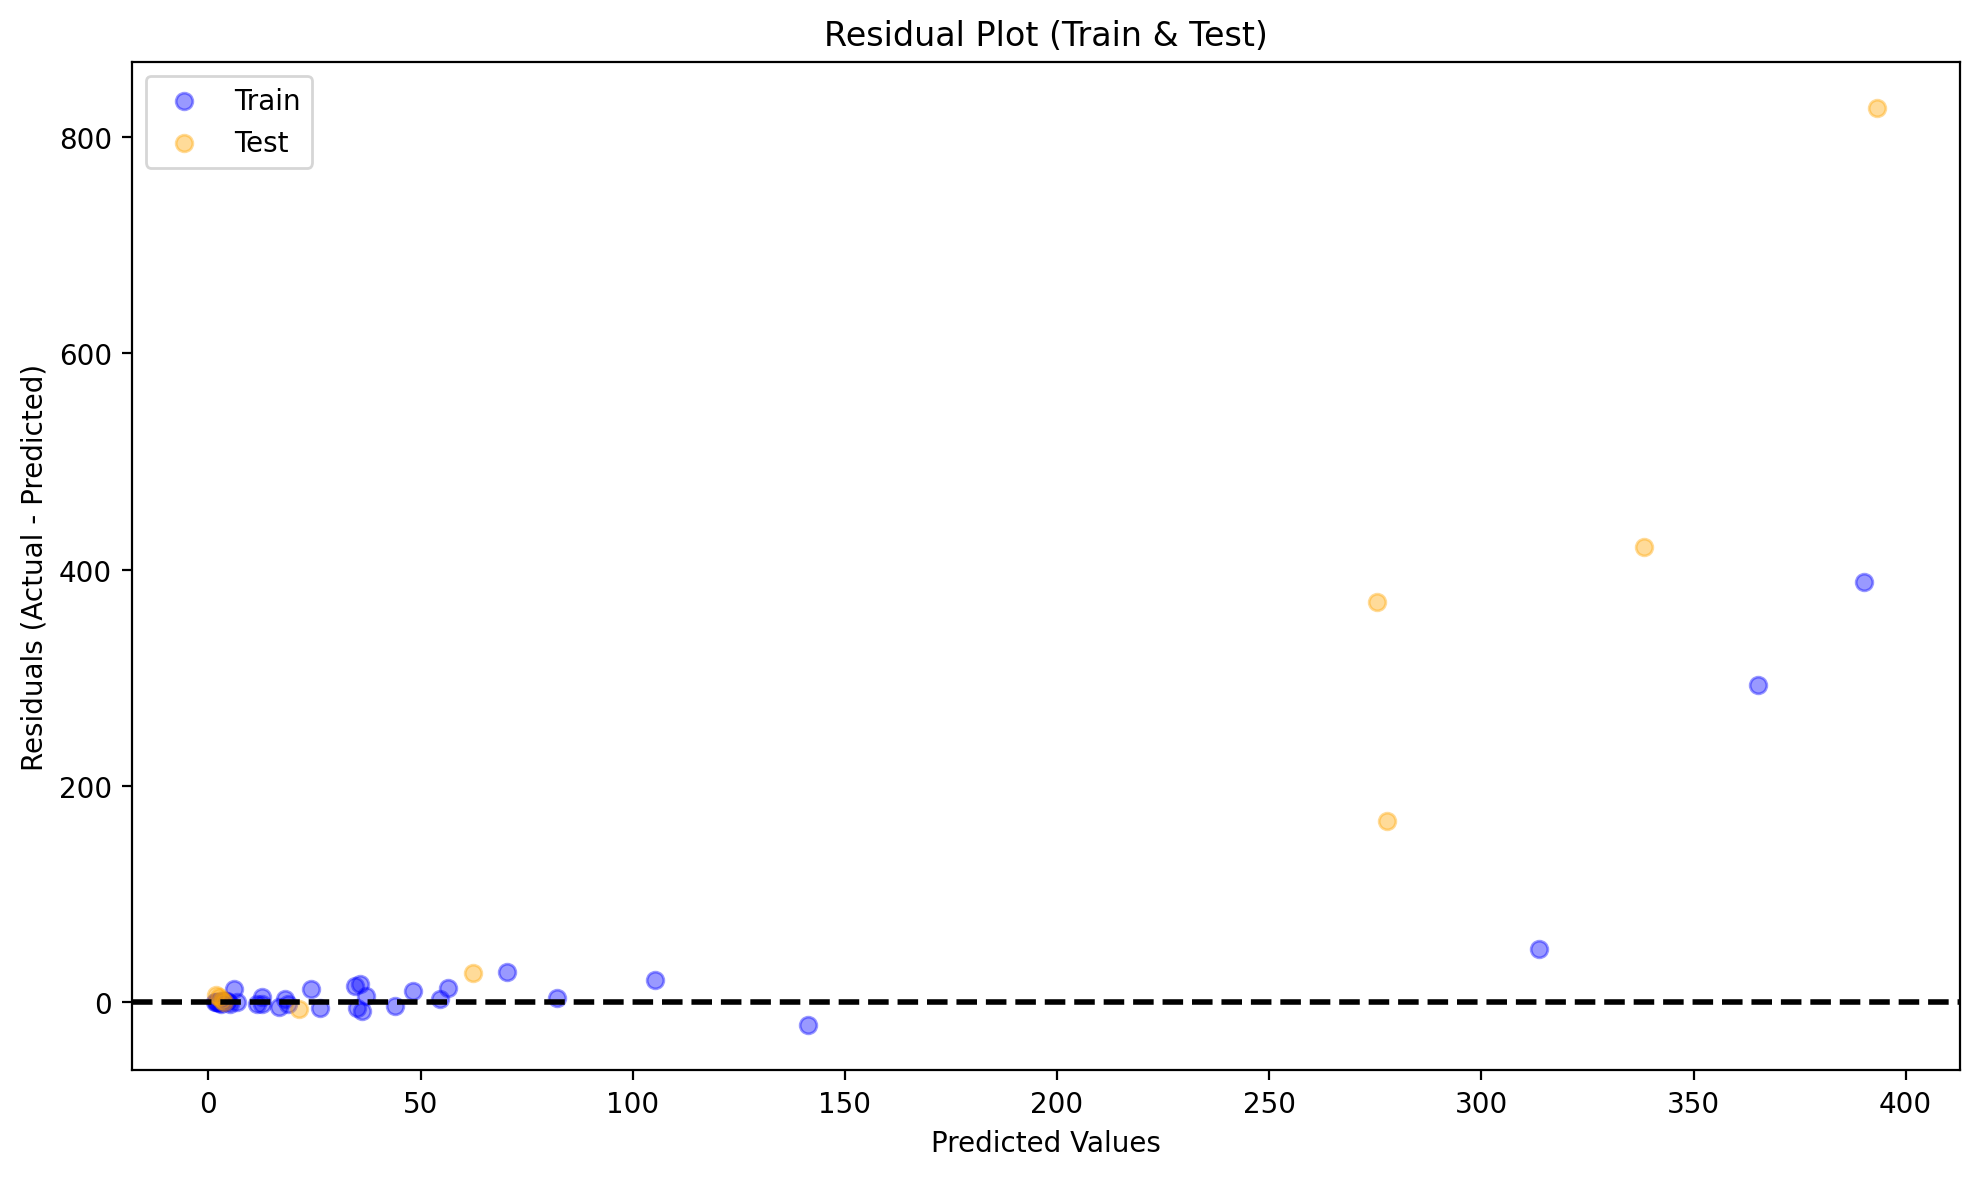

In [17]:
print("=" * 50)
print("Analysing: Total Guest Density (Number of guestes per km2)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_tourism_intensity_km2_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'])

## 4. Geographically Weighted Regression

In [18]:
# Drop rows with NaN values in the target column - this applies to all targets
edinburgh_airbnb_tourism_fs_clean = edinburgh_airbnb_tourism_fs.dropna(subset=['total_revenue'])

gwr_feature_columns = [
    "full_service_restaurant_density_log",
    "cultural_institution_density_log",
    "lodging_density_log",
    "fast_food_density_log",
    "retail_food_beverage_density_log"
]

Only have 48 towns in Edinburgh, therefore, this will not run.

## 5. Geographically Weighted Random Forest

### Total Revenue

In [25]:
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_revenue_log"
X_cols = features_logged

In [33]:
k_neighbors = 50  # number of spatial neighbors
predictions = []
tree = cKDTree(coords)

for i, point in enumerate(coords):
    # Original neighbors and distances
    distances, indices = tree.query(point, k=k_neighbors)
    raw_local_data = gdf.iloc[indices]

    # Drop rows with NA in target or predictors
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        continue

    # Get index mapping from cleaned data back to original indices
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Prepare local predictors and target
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # ---- Apply bisquare weights to only valid neighbors ----
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Normalize weights to sum to 1 for sampling
    prob = weights / weights.sum()

    # ---- Resample based on weights ----
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob, replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Predict
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

gdf["grf_prediction"] = predictions

Processed 0/55 points
Processed 50/55 points


In [34]:
# Mask for valid (non-missing) rows
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()

# Extract valid predictions and true values (log scale)
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# ---- Log-scale metrics ----
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# ---- Original-scale metrics ----
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

# ---- Print all metrics ----
print("GRF Evaluation Metrics")
print("-----------------------")
print(f"R² (log scale): {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
-----------------------
R² (log scale): 0.975
RMSE (log scale): 0.350
MAE  (log scale): 0.174
RMSE (original scale): 807,240.85
MAE  (original scale): 342,107.72


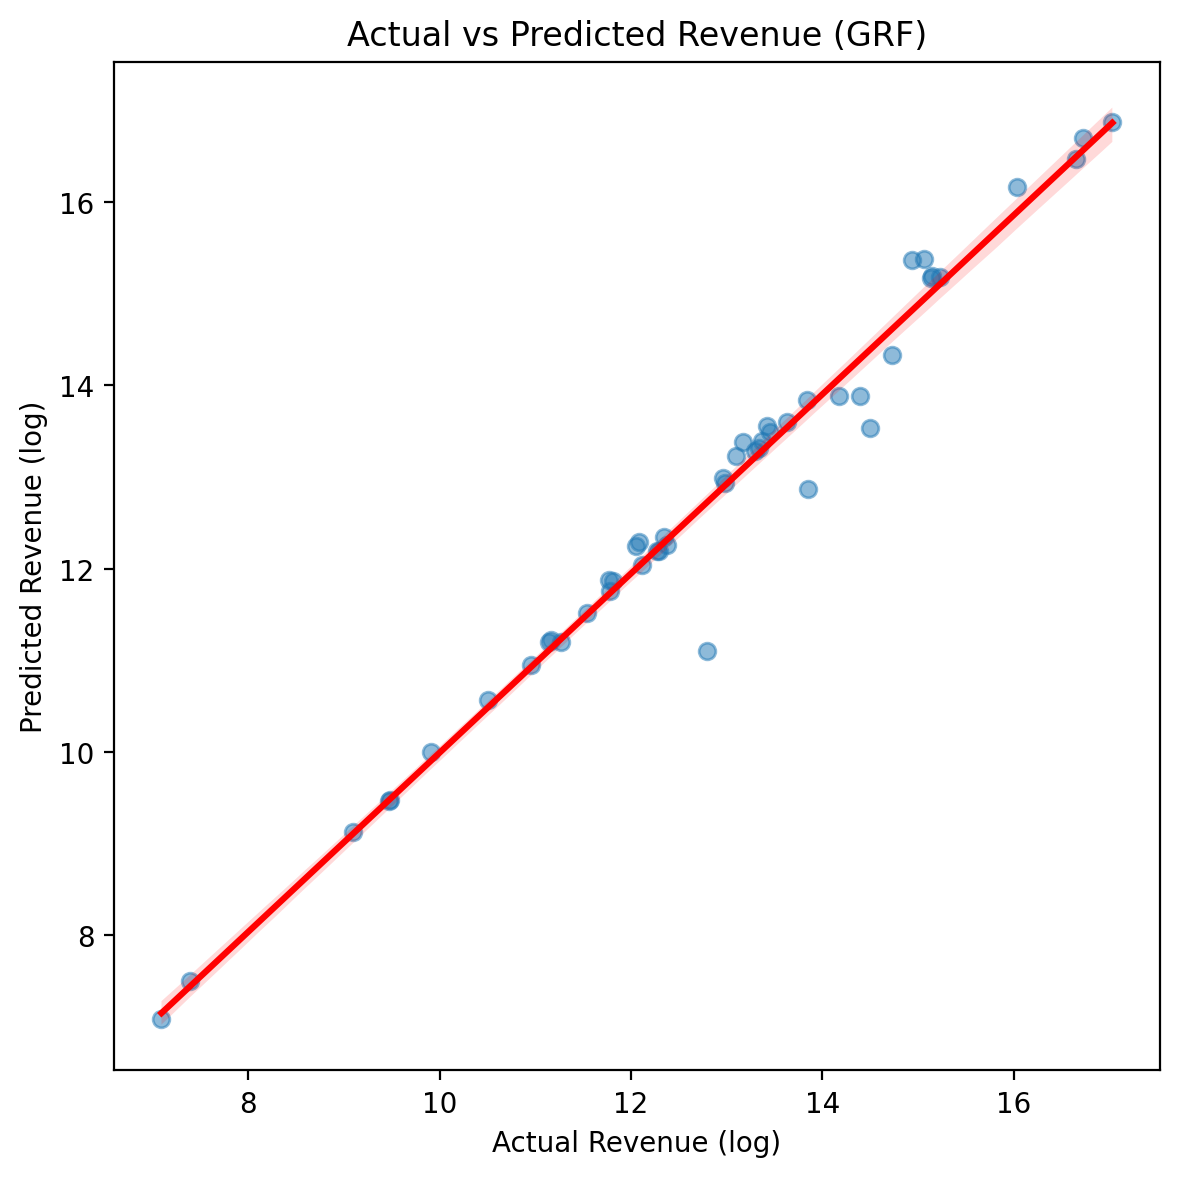

In [35]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [36]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Plot residuals using geopandas
gdf_valid = gdf[valid_mask]

gdf_valid.plot(column="grf_residual", cmap="coolwarm", legend=True,
               figsize=(8, 6), edgecolor='k', linewidth=0.5,
               legend_kwds={'label': "Residual (Predicted - Actual)",
                            'shrink': 0.6})
plt.title("Spatial Distribution of GRF Residuals")
plt.axis('off')
plt.show()

In [37]:
local_r2s = []  # store local R²

for i, point in enumerate(coords):
    # Get neighbors
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        continue

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Predict full local data (for R²)
    local_preds = rf.predict(local_data[X_cols])
    local_actuals = local_data[target]

    # Compute R² for local model on local data
    r2_local = r2_score(local_actuals, local_preds)
    local_r2s.append(r2_local)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

gdf["grf_local_r2"] = local_r2s

In [38]:
feature_importance_list = []

for i, point in enumerate(coords):
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Store feature importances
    feature_importance_list.append(rf.feature_importances_)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

importances_df = pd.DataFrame(feature_importance_list, columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

In [39]:
# Keep only importance columns
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Find the POI column with the highest importance for each row
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Clean names for labeling (optional)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "", regex=False)

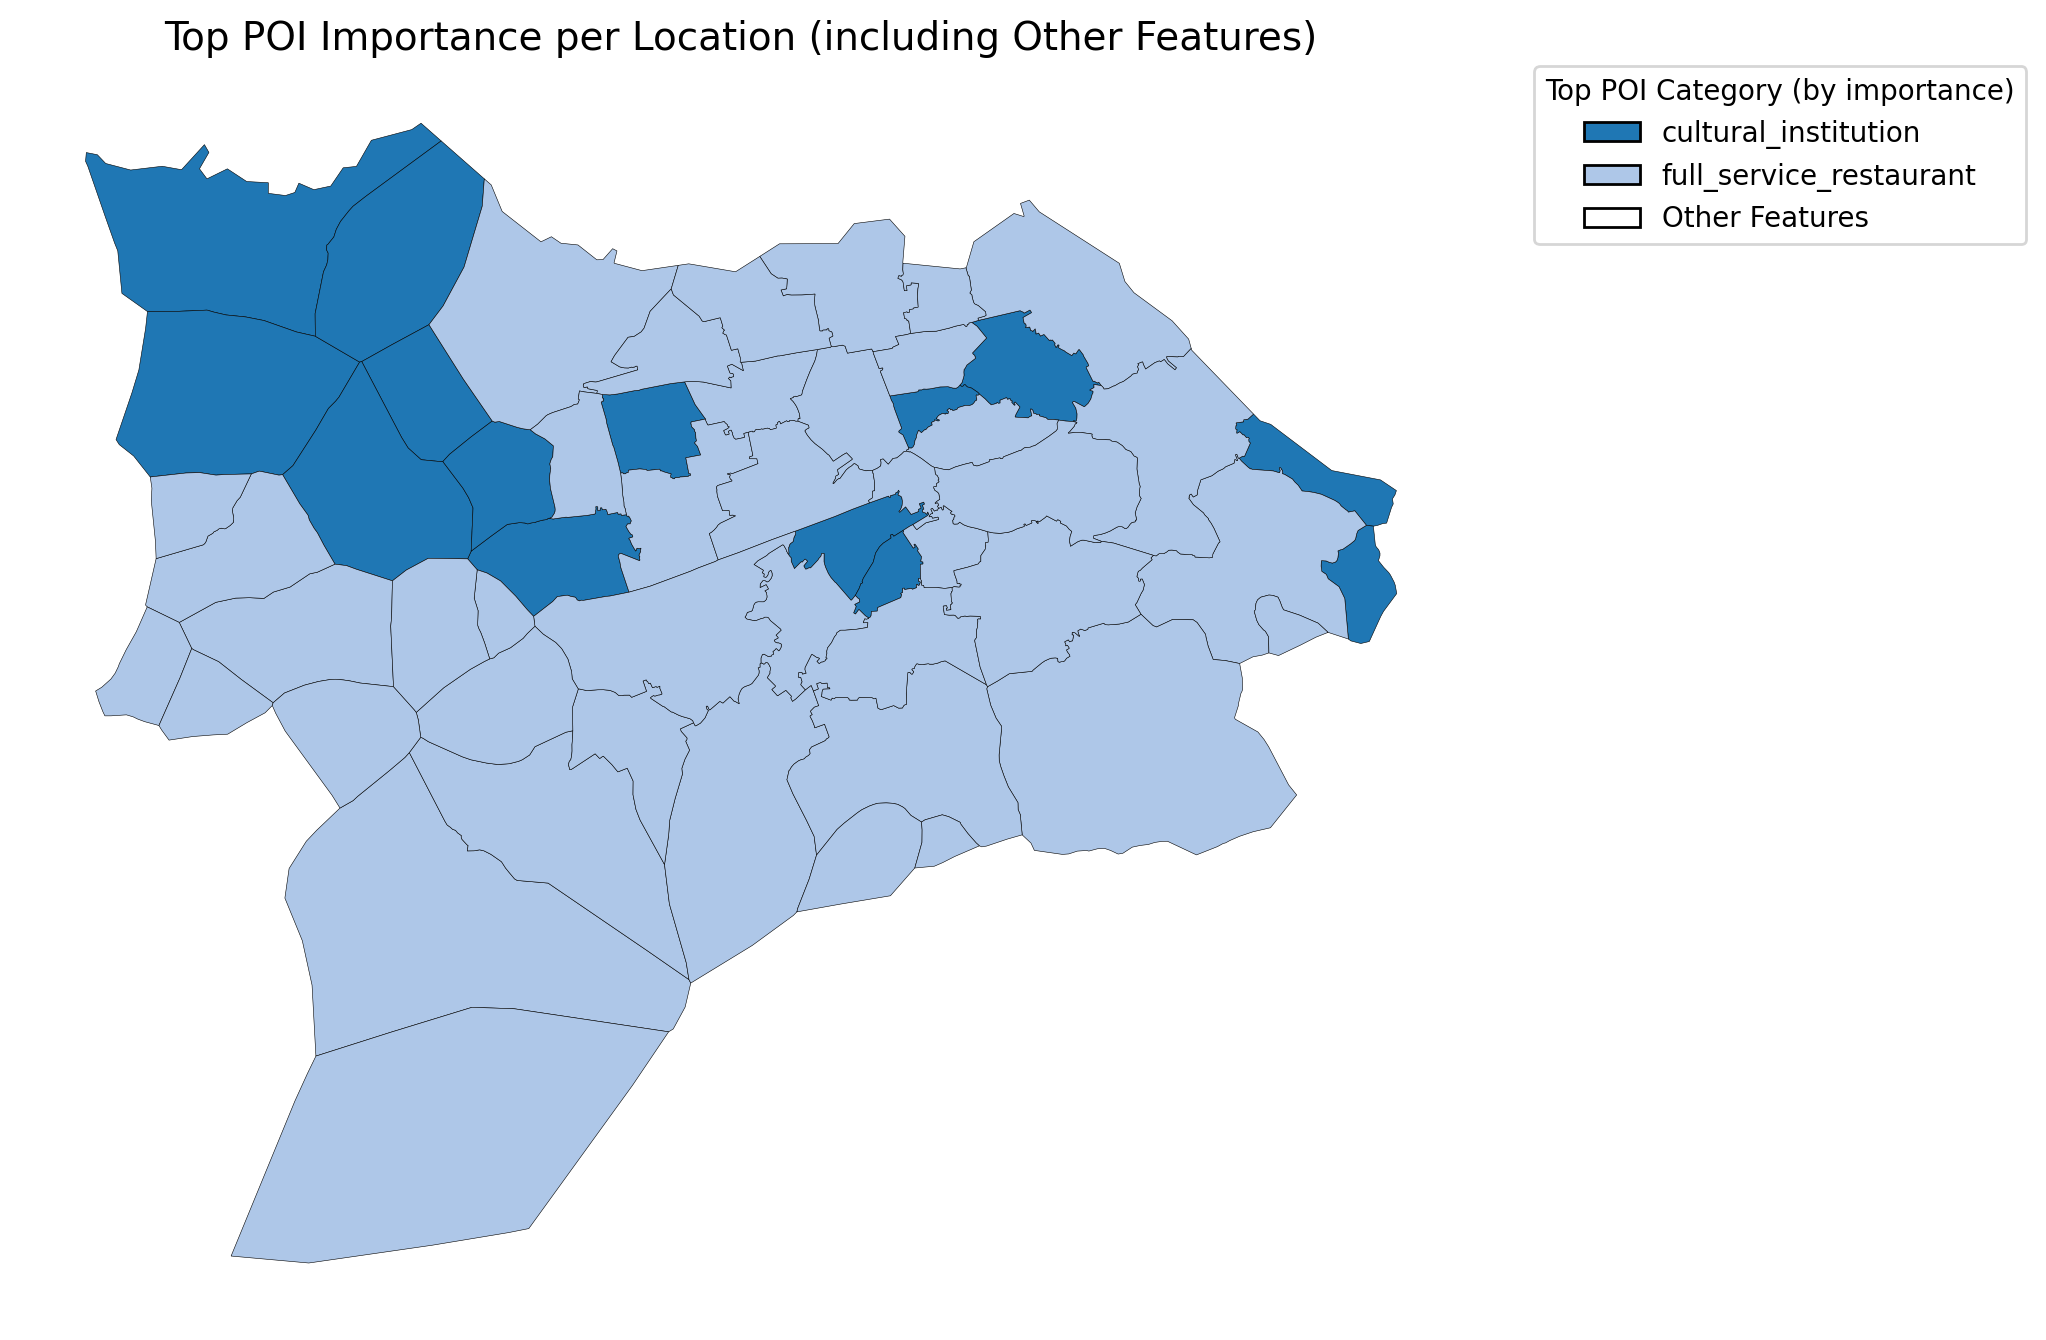

In [ ]:
# Assign 'Other Features' to less common POIs
top_n = 15
top_pois = (
    gdf["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

gdf["top_poi_plot"] = gdf["top_poi_clean"].where(gdf["top_poi_clean"].isin(top_pois), "Other Features")

# Build color map with white for 'Other Features'
unique_pois = sorted(set(top_pois))  # ensure order consistency
unique_pois.append("Other Features")  # make sure this is last

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors

# Assign white to 'Other Features'
poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
for poi, color in poi_color_map.items():
    subset = gdf[gdf["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, linewidth=0.2, edgecolor="black")

# Custom legend — with 'Other Features' last
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois  # maintains order with "Other Features" last
]

ax.legend(handles=legend_elements, title="Top POI Category (by importance)",
          bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Total Volume

In [63]:
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_volume_log"
X_cols = features_logged

In [64]:
k_neighbors = 10  # number of spatial neighbors
predictions = []
tree = cKDTree(coords)

for i, point in enumerate(coords):
    # Original neighbors and distances
    distances, indices = tree.query(point, k=k_neighbors)
    raw_local_data = gdf.iloc[indices]

    # Drop rows with NA in target or predictors
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        continue

    # Get index mapping from cleaned data back to original indices
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Prepare local predictors and target
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # ---- Apply bisquare weights to only valid neighbors ----
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Normalize weights to sum to 1 for sampling
    prob = weights / weights.sum()

    # ---- Resample based on weights ----
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob, replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Predict
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

gdf["grf_prediction"] = predictions

In [65]:
# Mask for valid (non-missing) rows
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()

# Extract valid predictions and true values (log scale)
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# ---- Log-scale metrics ----
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# ---- Original-scale metrics ----
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

# ---- Print all metrics ----
print("GRF Evaluation Metrics")
print("-----------------------")
print(f"R² (log scale): {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
-----------------------
R² (log scale): 0.946
RMSE (log scale): 0.360
MAE  (log scale): 0.171
RMSE (original scale): 50,916.39
MAE  (original scale): 20,466.92


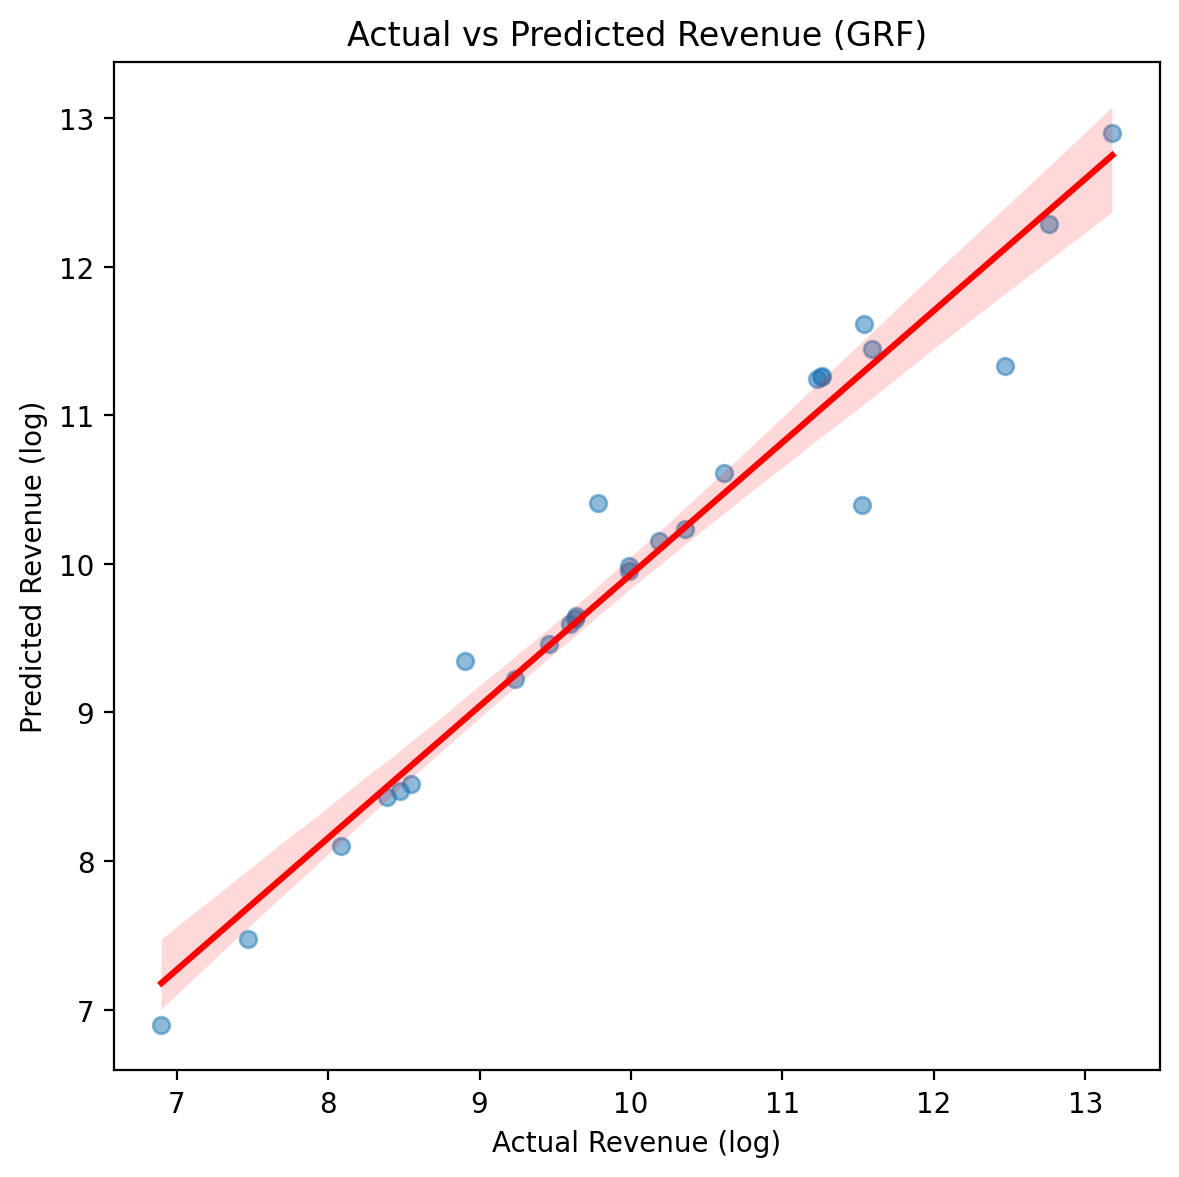

In [66]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

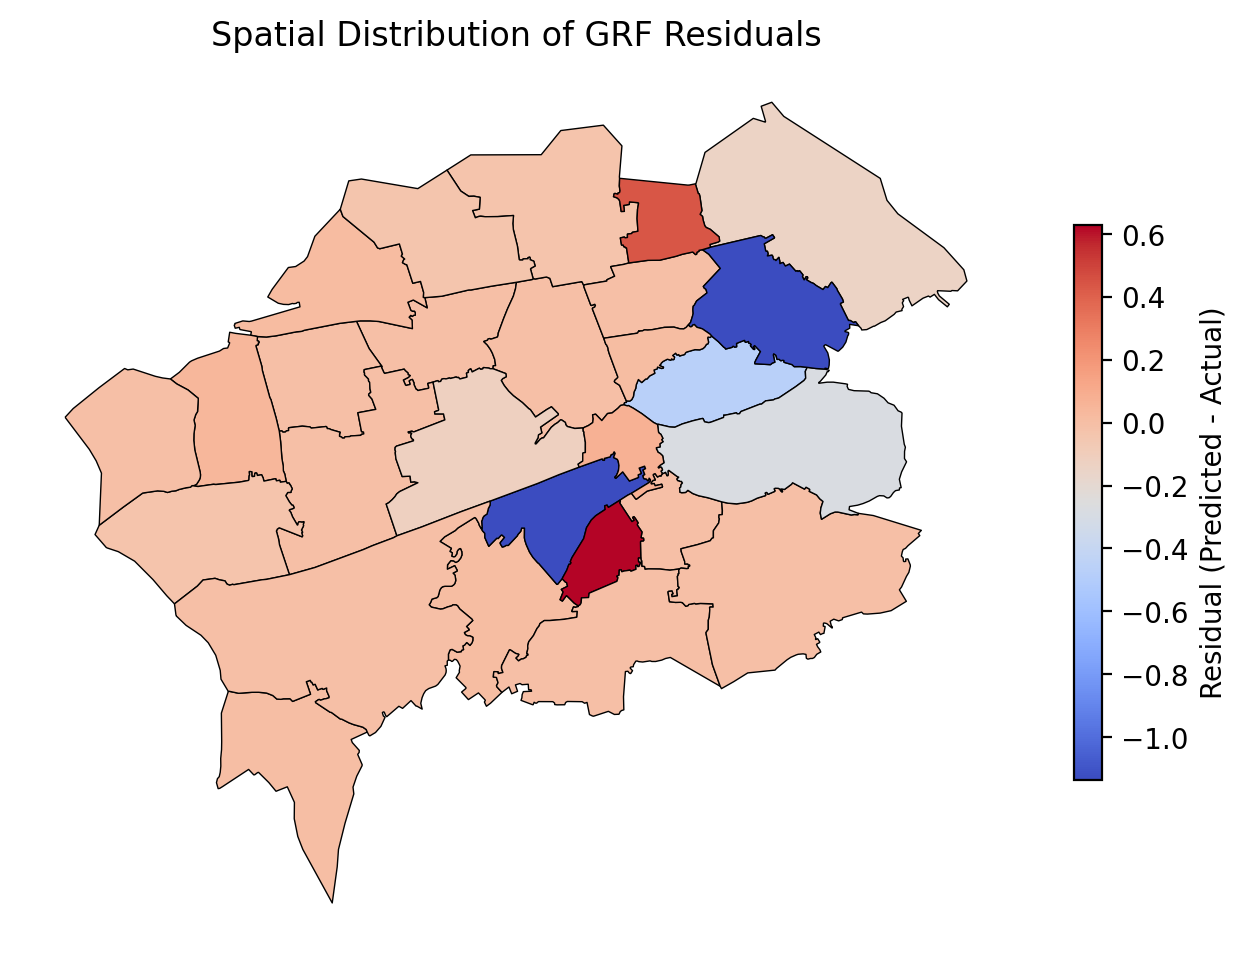

In [67]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Plot residuals using geopandas
gdf_valid = gdf[valid_mask]

gdf_valid.plot(column="grf_residual", cmap="coolwarm", legend=True,
               figsize=(8, 6), edgecolor='k', linewidth=0.5,
               legend_kwds={'label': "Residual (Predicted - Actual)",
                            'shrink': 0.6})
plt.title("Spatial Distribution of GRF Residuals")
plt.axis('off')
plt.show()

In [68]:
local_r2s = []  # store local R²

for i, point in enumerate(coords):
    # Get neighbors
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        continue

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Predict full local data (for R²)
    local_preds = rf.predict(local_data[X_cols])
    local_actuals = local_data[target]

    # Compute R² for local model on local data
    r2_local = r2_score(local_actuals, local_preds)
    local_r2s.append(r2_local)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

gdf["grf_local_r2"] = local_r2s

In [69]:
feature_importance_list = []

for i, point in enumerate(coords):
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Store feature importances
    feature_importance_list.append(rf.feature_importances_)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

importances_df = pd.DataFrame(feature_importance_list, columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

In [70]:
# Keep only importance columns
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Find the POI column with the highest importance for each row
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Clean names for labeling (optional)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "", regex=False)

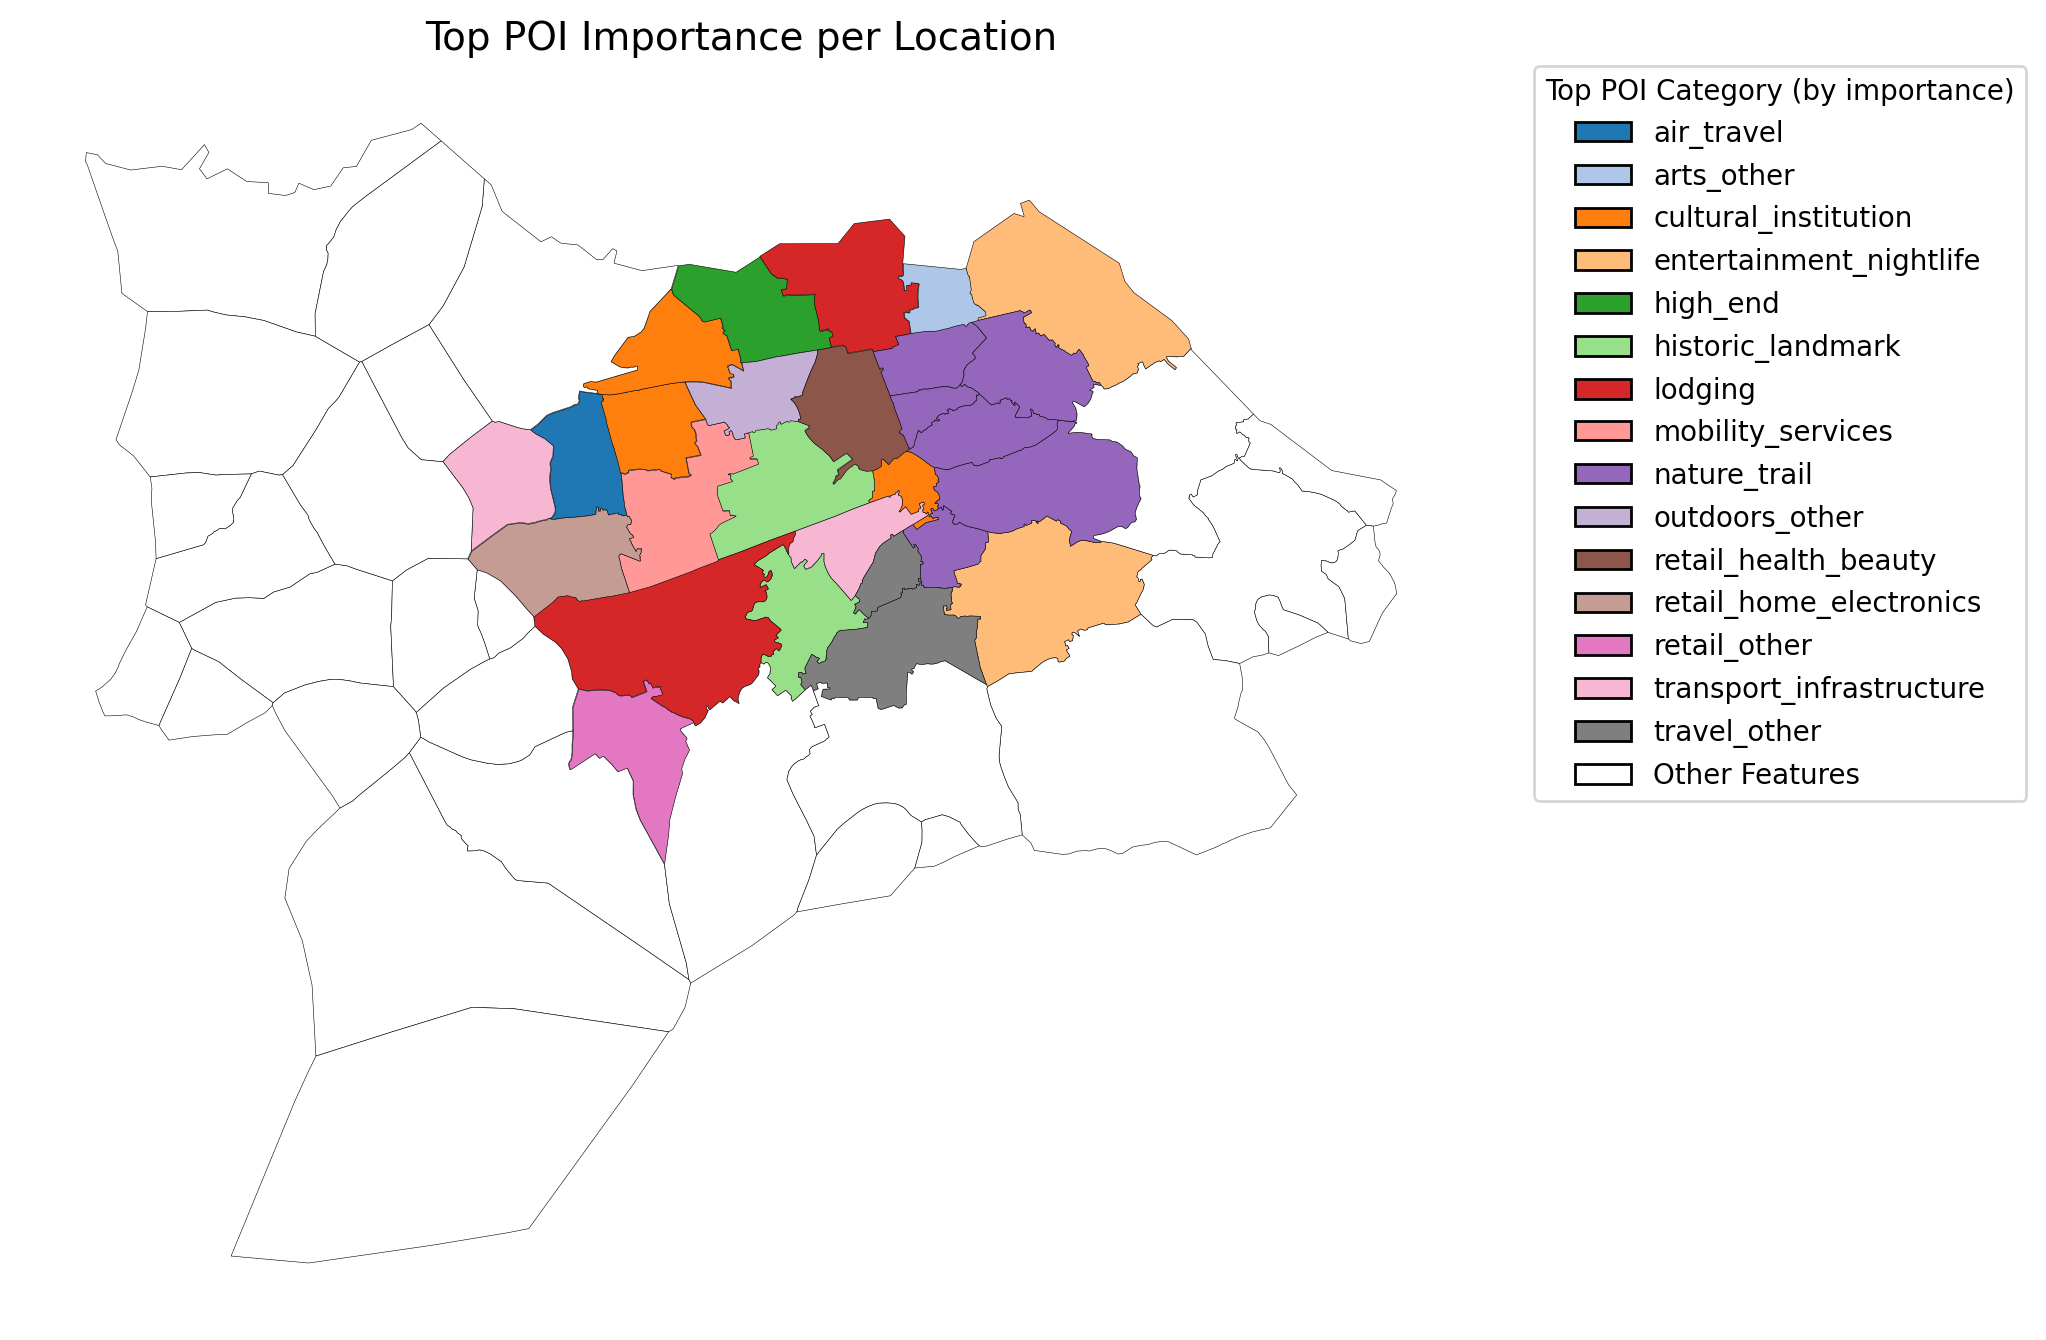

In [71]:
# Assign 'Other Features' to less common POIs
top_n = 15
top_pois = (
    gdf["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

gdf["top_poi_plot"] = gdf["top_poi_clean"].where(gdf["top_poi_clean"].isin(top_pois), "Other Features")

# Build color map with white for 'Other Features'
unique_pois = sorted(set(top_pois))  # ensure order consistency
unique_pois.append("Other Features")  # make sure this is last

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors

# Assign white to 'Other Features'
poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
for poi, color in poi_color_map.items():
    subset = gdf[gdf["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, linewidth=0.2, edgecolor="black")

# Custom legend — with 'Other Features' last
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois  # maintains order with "Other Features" last
]

ax.legend(handles=legend_elements, title="Top POI Category (by importance)",
          bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Guest Density

In [52]:
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_tourism_intensity_km2_log"
X_cols = features_logged

In [55]:
k_neighbors = 10  # number of spatial neighbors
predictions = []
tree = cKDTree(coords)

for i, point in enumerate(coords):
    # Original neighbors and distances
    distances, indices = tree.query(point, k=k_neighbors)
    raw_local_data = gdf.iloc[indices]

    # Drop rows with NA in target or predictors
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        continue

    # Get index mapping from cleaned data back to original indices
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Prepare local predictors and target
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # ---- Apply bisquare weights to only valid neighbors ----
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Normalize weights to sum to 1 for sampling
    prob = weights / weights.sum()

    # ---- Resample based on weights ----
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob, replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Predict
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

gdf["grf_prediction"] = predictions

In [56]:
# Mask for valid (non-missing) rows
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()

# Extract valid predictions and true values (log scale)
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# ---- Log-scale metrics ----
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# ---- Original-scale metrics ----
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

# ---- Print all metrics ----
print("GRF Evaluation Metrics")
print("-----------------------")
print(f"R² (log scale): {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
-----------------------
R² (log scale): 0.995
RMSE (log scale): 0.111
MAE  (log scale): 0.046
RMSE (original scale): 25.78
MAE  (original scale): 7.91


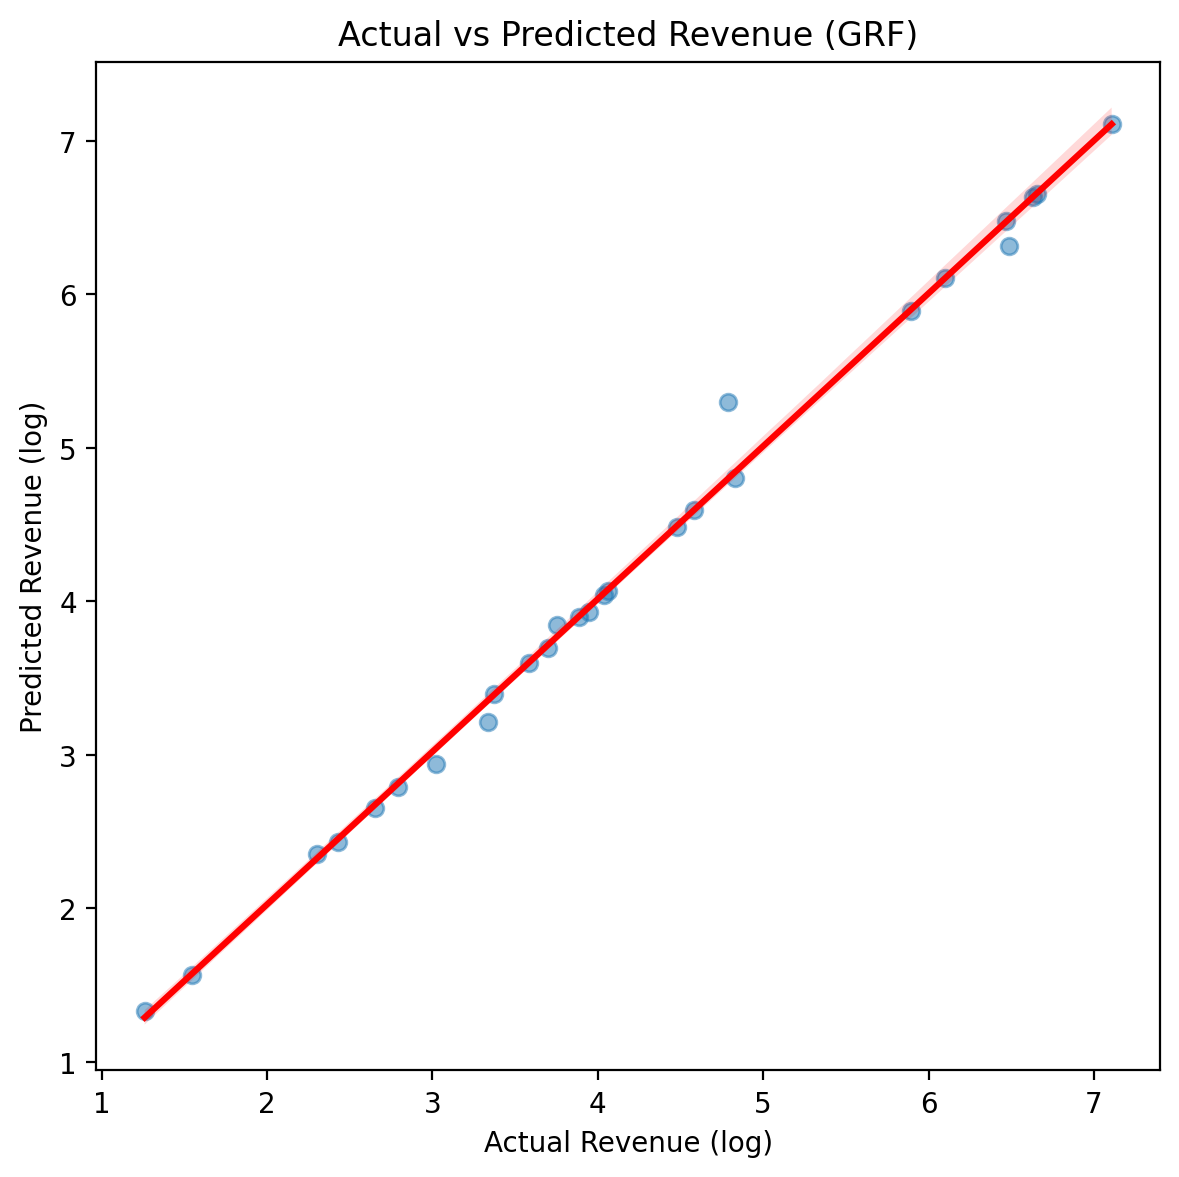

In [57]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

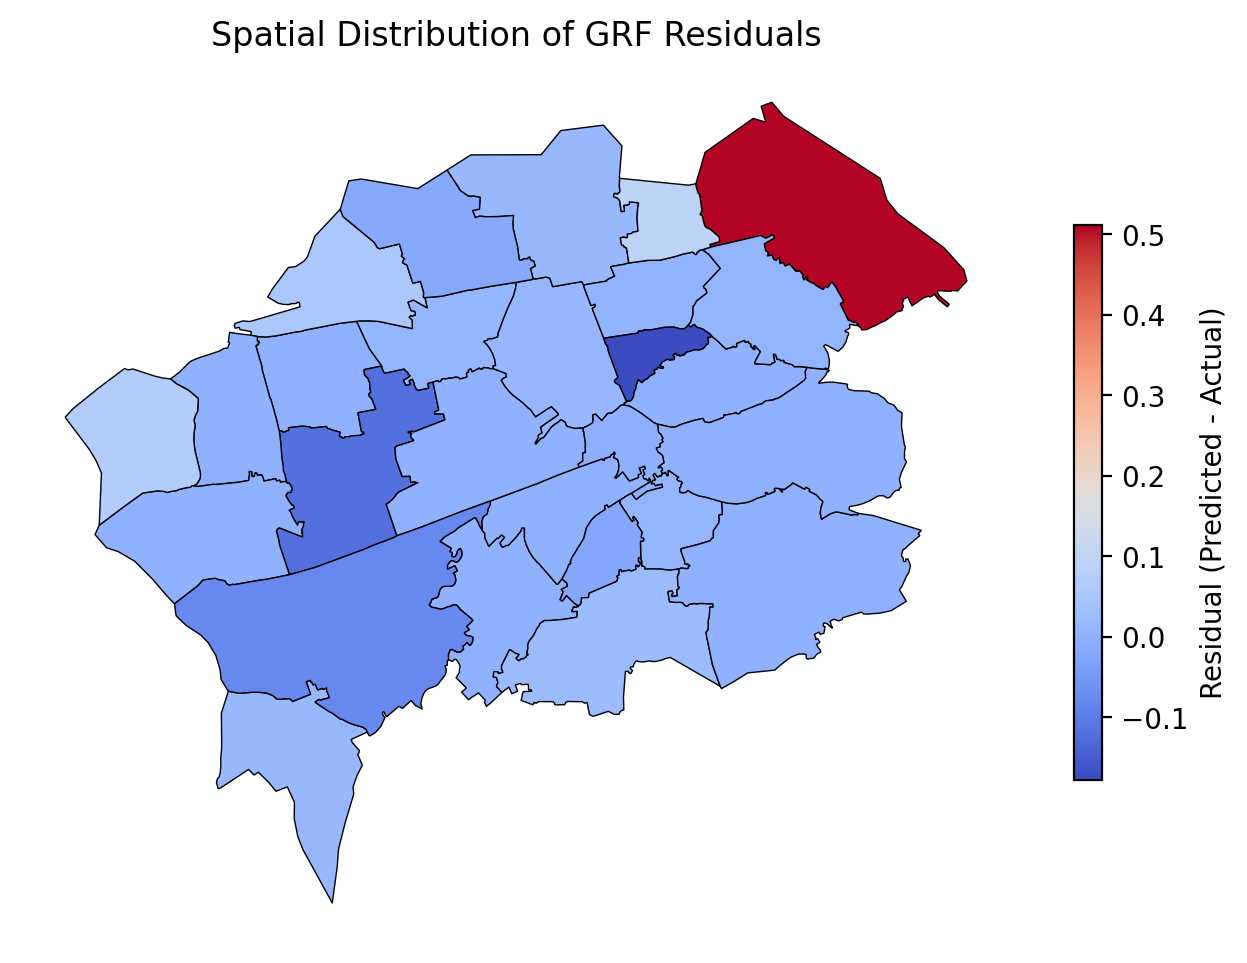

In [58]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Plot residuals using geopandas
gdf_valid = gdf[valid_mask]

gdf_valid.plot(column="grf_residual", cmap="coolwarm", legend=True,
               figsize=(8, 6), edgecolor='k', linewidth=0.5,
               legend_kwds={'label': "Residual (Predicted - Actual)",
                            'shrink': 0.6})
plt.title("Spatial Distribution of GRF Residuals")
plt.axis('off')
plt.show()

In [59]:
local_r2s = []  # store local R²

for i, point in enumerate(coords):
    # Get neighbors
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        continue

    # Fit local model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Predict full local data (for R²)
    local_preds = rf.predict(local_data[X_cols])
    local_actuals = local_data[target]

    # Compute R² for local model on local data
    r2_local = r2_score(local_actuals, local_preds)
    local_r2s.append(r2_local)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

gdf["grf_local_r2"] = local_r2s

In [60]:
feature_importance_list = []

for i, point in enumerate(coords):
    distances, indices = tree.query(point, k=k_neighbors)
    local_data = gdf.iloc[indices].dropna(subset=[target] + X_cols)

    if len(local_data) < 10:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(local_data[X_cols], local_data[target])

    # Store feature importances
    feature_importance_list.append(rf.feature_importances_)

    # Predict for center point
    center_pred = rf.predict(gdf.iloc[[i]][X_cols])[0]
    predictions.append(center_pred)

importances_df = pd.DataFrame(feature_importance_list, columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

In [61]:
# Keep only importance columns
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Find the POI column with the highest importance for each row
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Clean names for labeling (optional)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "", regex=False)

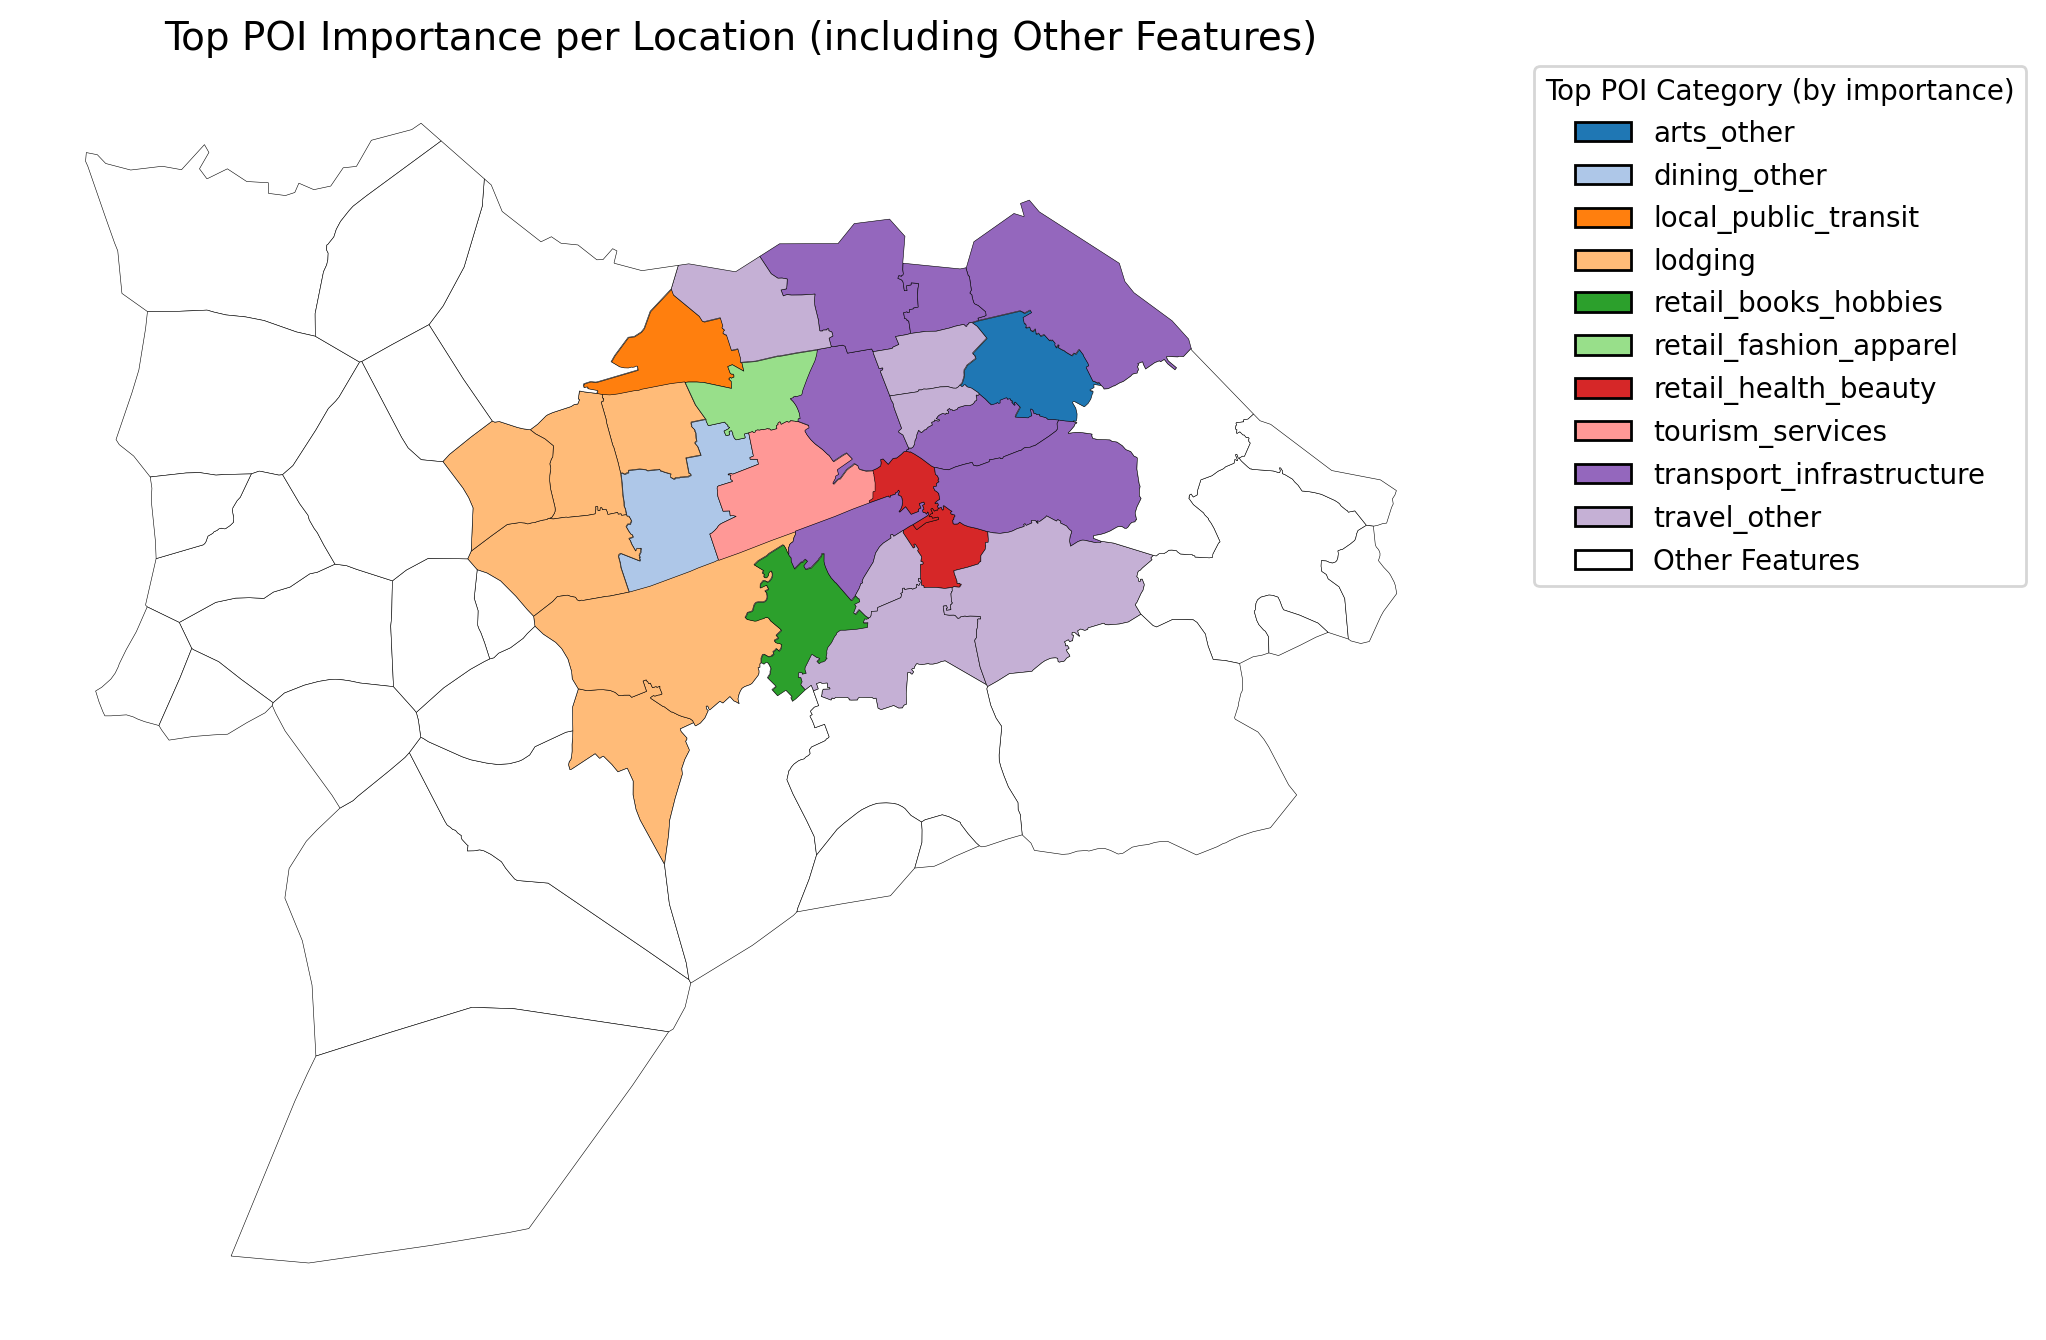

In [62]:
# Assign 'Other Features' to less common POIs
top_n = 15
top_pois = (
    gdf["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

gdf["top_poi_plot"] = gdf["top_poi_clean"].where(gdf["top_poi_clean"].isin(top_pois), "Other Features")

# Build color map with white for 'Other Features'
unique_pois = sorted(set(top_pois))  # ensure order consistency
unique_pois.append("Other Features")  # make sure this is last

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors

# Assign white to 'Other Features'
poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
for poi, color in poi_color_map.items():
    subset = gdf[gdf["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, linewidth=0.2, edgecolor="black")

# Custom legend — with 'Other Features' last
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois  # maintains order with "Other Features" last
]

ax.legend(handles=legend_elements, title="Top POI Category (by importance)",
          bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.title("Top POI Importance per Location (including Other Features)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()